<a href="https://colab.research.google.com/github/YouCanKeepSilence/ml_labs/blob/master/ML_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт данных

In [1]:
import keras
import pandas as pd

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Загружаем данные из .csv

In [0]:
names_array = ['gender', 'age', 'first_label', 'second_label', 'third_label', *['c_{}'.format(i + 1) for i in range(60000)]]
url = '/content/drive/My Drive/ML/half.csv'
data = pd.read_csv(url, names=names_array)

# Обработка данных

Удаляем ненужные стобцы (по причине малого количества данных в них)

In [0]:
data = data.drop(['second_label', 'third_label'], axis=1)

In [5]:
data

,gender,age,first_label,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,c_15,c_16,c_17,c_18,c_19,c_20,c_21,c_22,c_23,c_24,c_25,c_26,c_27,c_28,c_29,c_30,c_31,c_32,c_33,c_34,c_35,c_36,c_37,...,c_59961,c_59962,c_59963,c_59964,c_59965,c_59966,c_59967,c_59968,c_59969,c_59970,c_59971,c_59972,c_59973,c_59974,c_59975,c_59976,c_59977,c_59978,c_59979,c_59980,c_59981,c_59982,c_59983,c_59984,c_59985,c_59986,c_59987,c_59988,c_59989,c_59990,c_59991,c_59992,c_59993,c_59994,c_59995,c_59996,c_59997,c_59998,c_59999,c_60000
0,Female,85,3,0.003242,0.012132,0.022637,0.010953,-0.024891,-0.032752,-0.031432,-0.042890,-0.048659,-0.037955,-0.026816,-0.017216,-0.014815,-0.024370,-0.027953,-0.037105,-0.046662,-0.052641,-0.054785,-0.054178,-0.034856,-0.023726,-0.036748,-0.031842,-0.021913,-0.038332,-0.045422,-0.044497,-0.042550,-0.038772,-0.043089,-0.055117,-0.062105,-0.062300,-0.062635,-0.068795,-0.070163,...,-0.026842,-0.028914,-0.028548,-0.029272,-0.031896,-0.036031,-0.039794,-0.033593,-0.028113,-0.031301,-0.041995,-0.045999,-0.043968,-0.039291,-0.030942,-0.031698,-0.030754,-0.033479,-0.033446,-0.036413,-0.038551,-0.035920,-0.036477,-0.036518,-0.041184,-0.039042,-0.033992,-0.033940,-0.031528,-0.026267,-0.028246,-0.028318,-0.025569,-0.021279,-0.018593,-0.032023,-0.046202,-0.042003,-0.034466,-0.039000
1,Male,79,9,0.012054,0.017017,0.015951,0.020941,0.020960,0.021158,0.021051,0.021062,0.021122,0.021278,0.026533,0.026235,0.016037,0.013366,0.013222,0.008356,0.005556,0.007938,0.008593,0.008398,0.008547,0.008369,0.008677,0.006235,0.000651,-0.001857,-0.001712,-0.007047,-0.009004,-0.012014,-0.019256,-0.019027,-0.019518,-0.018919,-0.020128,-0.021534,-0.024676,...,-0.934049,-0.949376,-0.962051,-0.963686,-0.961742,-0.952030,-0.939060,-0.934415,-0.936366,-0.939326,-0.932011,-0.926725,-0.928331,-0.929013,-0.921389,-0.906309,-0.900787,-0.901273,-0.895911,-0.893740,-0.891627,-0.885869,-0.881577,-0.873489,-0.866113,-0.865862,-0.859139,-0.852907,-0.843380,-0.833925,-0.833698,-0.836701,-0.827418,-0.827810,-0.816231,-0.819793,-0.797862,-0.819597,-0.771195,-0.845490
2,Male,66,3,-0.009508,-0.008508,-0.009508,-0.008508,-0.007508,-0.006508,-0.006508,-0.006508,-0.005508,-0.006508,-0.005508,-0.004508,-0.003508,-0.004508,-0.004508,-0.004508,-0.005508,-0.004508,-0.003508,-0.004508,-0.003508,-0.002508,-0.000508,-0.001508,-0.000508,-0.000508,-0.001508,-0.001508,-0.001508,-0.000508,0.000492,0.002492,0.005492,0.006492,0.007492,0.008492,0.008492,...,-0.051053,-0.052053,-0.051053,-0.049053,-0.047053,-0.044053,-0.040053,-0.037053,-0.036053,-0.034053,-0.034053,-0.034053,-0.033053,-0.031053,-0.028053,-0.025053,-0.022053,-0.019053,-0.017053,-0.017053,-0.016053,-0.016053,-0.014053,-0.013053,-0.010053,-0.007053,-0.003053,0.001947,0.004947,0.007947,0.009947,0.011947,0.012947,0.015947,0.018947,0.023947,0.027947,0.030947,0.034947,0.037947
3,Male,93,2,-0.002271,0.004177,-0.002077,-0.005875,-0.004685,-0.008117,-0.019722,-0.036185,-0.037616,-0.025323,-0.023199,-0.035744,-0.043484,-0.030469,-0.022611,-0.010540,0.004805,0.020337,0.029668,0.017382,0.004737,0.002755,0.014075,0.015677,0.002024,-0.002544,0.000068,0.000271,0.011654,0.022805,0.028631,0.029834,0.030584,0.035327,0.051485,0.059849,0.036704,...,-0.117502,-0.208445,-0.254530,-0.270954,-0.254278,-0.223832,-0.205055,-0.179093,-0.157585,-0.127692,-0.089728,-0.074150,-0.056856,-0.038932,-0.024184,-0.016817,-0.014031,-0.011765,-0.022771,-0.023586,-0.013769,-0.004949,-0.003625,-0.013567,-0.019471,-0.015372,-0.021787,-0.028885,-0.028997,-0.021737,-0.013160,-0.006182,-0.003825,-0.002177,-0.001466,-0.006676,-0.011236,-0.016540,-0.016289,-0.022542
4,Male,65,2,-0.030600,-0.027425,-0.013923,-0.023743,-0.024572,-0.036078,-0.034740,-0.013670,-0.009571,-0.022441,-0.033034,-0.032663,-0.018181,-0.017317,-0.030576,-0.032829,-0.010305,0.005287,0.006696,-0.002352,-0.005559,-0.005361,-0.008254,0.002175,0.007531,0.002662,0.000376,-0.007697,-0.016977,-0.009894,-0.000388,-0.012127,-0.007840,-0.002470,-0.005233,0.004789,-0.007276,...,1.016910,0.710028,0.4

## Аугментируем данные

Увеличим кол-во образцов, одновременно уменьшив число признаков. Оставим 1000 измерений для каждой записи. Каждый последующий отрезок будем формировать в отдельную запись

In [30]:
# batch_size = 1000
measurment_names = data.columns[3:]
new_data = pd.DataFrame()

# i = batch_size * 2
# current_measurment_names = {f'c_{j + 1}': f'c_{j % batch_size + 1}' for j in range(i, i + batch_size)}
# data[['age', 'gender', 'first_label', *[f'c_{j + 1}' for j in range(i, i + batch_size)]]].rename(columns=current_measurment_names)

# for i in range(0, len(measurment_names), batch_size):
#  current_measurment_names = {f'c_{j + 1}': f'c_{j % batch_size + 1}' for j in range(i, i + batch_size)}
#  mapped_piece = data[['age', 'gender', 'first_label', *[f'c_{j + 1}' for j in range(i, i + batch_size)]]].rename(columns=current_measurment_names)
#  new_data = pd.concat([new_data, mapped_piece])

# Пользуемся тем, что имеем 5к измерений для каждого из 12 датчиков. Соответственно нарежем по 250 с каждого из 12 датчиков
new_batch = 250
measurments_for_sensors = 5000
sensors_count = 12
for i in range(0, measurments_for_sensors, new_batch):
    current_measurment_names = {f'c_{k + j * measurments_for_sensors + 1}': f'c_{(new_batch * j + k % new_batch) % (new_batch * sensors_count)  + 1}' for j in range(sensors_count) for k in range(i, i + new_batch)}
    mapped_piece = data[['age', 'gender', 'first_label', *[f'c_{k + j * measurments_for_sensors + 1}'  for j in range(sensors_count) for k in range(i, i + new_batch)]]].rename(columns=current_measurment_names)
    new_data = pd.concat([new_data, mapped_piece])


new_data

,age,gender,first_label,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,c_15,c_16,c_17,c_18,c_19,c_20,c_21,c_22,c_23,c_24,c_25,c_26,c_27,c_28,c_29,c_30,c_31,c_32,c_33,c_34,c_35,c_36,c_37,...,c_2961,c_2962,c_2963,c_2964,c_2965,c_2966,c_2967,c_2968,c_2969,c_2970,c_2971,c_2972,c_2973,c_2974,c_2975,c_2976,c_2977,c_2978,c_2979,c_2980,c_2981,c_2982,c_2983,c_2984,c_2985,c_2986,c_2987,c_2988,c_2989,c_2990,c_2991,c_2992,c_2993,c_2994,c_2995,c_2996,c_2997,c_2998,c_2999,c_3000
0,85,Female,3,0.003242,0.012132,0.022637,0.010953,-0.024891,-0.032752,-0.031432,-0.042890,-0.048659,-0.037955,-0.026816,-0.017216,-0.014815,-0.024370,-0.027953,-0.037105,-0.046662,-0.052641,-0.054785,-0.054178,-0.034856,-0.023726,-0.036748,-0.031842,-0.021913,-0.038332,-0.045422,-0.044497,-0.042550,-0.038772,-0.043089,-0.055117,-0.062105,-0.062300,-0.062635,-0.068795,-0.070163,...,-0.042165,-0.038295,-0.031430,-0.030939,-0.026489,-0.026416,-0.023869,-0.018956,-0.018332,-0.012197,-0.010827,-0.010946,-0.005748,-0.003529,-0.001014,0.008721,0.006861,0.008915,0.013527,0.016897,0.026238,0.032369,0.039158,0.039443,0.046263,0.052320,0.061813,0.064635,0.064673,0.064160,0.076964,0.099699,0.109083,0.115720,0.124500,0.135699,0.142533,0.157333,0.168144,0.167612
1,79,Male,9,0.012054,0.017017,0.015951,0.020941,0.020960,0.021158,0.021051,0.021062,0.021122,0.021278,0.026533,0.026235,0.016037,0.013366,0.013222,0.008356,0.005556,0.007938,0.008593,0.008398,0.008547,0.008369,0.008677,0.006235,0.000651,-0.001857,-0.001712,-0.007047,-0.009004,-0.012014,-0.019256,-0.019027,-0.019518,-0.018919,-0.020128,-0.021534,-0.024676,...,0.212629,0.212099,0.207610,0.202372,0.197213,0.187022,0.179713,0.174762,0.177674,0.184897,0.191746,0.197086,0.198039,0.200046,0.200121,0.197289,0.187370,0.175233,0.158778,0.142246,0.132504,0.133914,0.141448,0.147200,0.149907,0.149108,0.151819,0.149426,0.139453,0.129564,0.126670,0.126786,0.128829,0.129041,0.124646,0.116546,0.101771,0.086233,0.073918,0.061897
2,66,Male,3,-0.009508,-0.008508,-0.009508,-0.008508,-0.007508,-0.006508,-0.006508,-0.006508,-0.005508,-0.006508,-0.005508,-0.004508,-0.003508,-0.004508,-0.004508,-0.004508,-0.005508,-0.004508,-0.003508,-0.004508,-0.003508,-0.002508,-0.000508,-0.001508,-0.000508,-0.000508,-0.001508,-0.001508,-0.001508,-0.000508,0.000492,0.002492,0.005492,0.006492,0.007492,0.008492,0.008492,...,-0.016053,-0.017053,-0.020053,-0.022053,-0.023053,-0.024053,-0.024053,-0.023053,-0.023053,-0.023053,-0.024053,-0.025053,-0.028053,-0.030053,-0.032053,-0.032053,-0.032053,-0.031053,-0.029053,-0.028053,-0.027053,-0.028053,-0.028053,-0.028053,-0.028053,-0.028053,-0.027053,-0.026053,-0.025053,-0.024053,-0.024053,-0.025053,-0.027053,-0.029053,-0.030053,-0.031053,-0.032053,-0.032053,-0.032053,-0.032053
3,93,Male,2,-0.002271,0.004177,-0.002077,-0.005875,-0.004685,-0.008117,-0.019722,-0.036185,-0.037616,-0.025323,-0.023199,-0.035744,-0.043484,-0.030469,-0.022611,-0.010540,0.004805,0.020337,0.029668,0.017382,0.004737,0.002755,0.014075,0.015677,0.002024,-0.002544,0.000068,0.000271,0.011654,0.022805,0.028631,0.029834,0.030584,0.035327,0.051485,0.059849,0.036704,...,1.231641,1.184278,0.984192,0.756997,0.542910,0.319415,0.119338,-0.071326,-0.200446,-0.274568,-0.318679,-0.322228,-0.294194,-0.261829,-0.233143,-0.208244,-0.184876,-0.160516,-0.140754,-0.124244,-0.121719,-0.111981,-0.094989,-0.074455,-0.061890,-0.059022,-0.059572,-0.059001,-0.061746,-0.067160,-0.077408,-0.082138,-0.076787,-0.072755,-0.077115,-0.079757,-0.079575,-0.077995,-0.083645,-0.090060
4,65,Male,2,-0.030600,-0.027425,-0.013923,-0.023743,-0.024572,-0.036078,-0.034740,-0.013670,-0.009571,-0.022441,-0.033034,-0.032663,-0.018181,-0.017317,-0.030576,-0.032829,-0.010305,0.005287,0.006696,-0.002352,-0.005559,-0.005361,-0.008254,0.002175,0.007531,0.002662,0.000376,-0.007697,-0.016977,-0.009894,-0.000388,-0.012127,-0.007840,-0.002470,-0.005233,0.004789,-0.007276,...,-0.064945,-0.069677,-0.072775,-0.069443,-0.067366,-0.071764,-0.072349,-0.071588,-0.067871,-0.064693,-0.059544,-0.056611,

Таким образом получаем из размерности 1250, 60003 -> 25000, 3003 увеличив количество записей в датасете в 20 раз.



## Обработаем пропущенные значения

In [31]:
print(new_data['age'].unique())
print(new_data['gender'].unique())
print(new_data['first_label'].unique())
print(new_data.isnull().sum())

[85 79 66 93 65 55 82 87 51 61 90 77 70 60 62 59 84 71 45 48 75 49 72 78
 86 46 94 33 74 64 67 63 88 32 92 68 76 54 89 31 80 30 57 83 34 27 73 69
 52 44 43 47 39 56 81 53 50 16 29 37 58 24 22 40 41 11 26 28 96 35 91 25
 36 23 19 17 42 18 15  8 20 38 14 21]
['Female' 'Male']
[3 9 2 5 1 7 6 4 8]
age            0
gender         0
first_label    0
c_1            0
c_2            0
              ..
c_2996         0
c_2997         0
c_2998         0
c_2999         0
c_3000         0
Length: 3003, dtype: int64


Пропущенных значений нет.

## Обработаем категориальные признаки

In [32]:
categorial_columns = ['gender', 'first_label']
numerical_columns = ['age', *[f'c_{i + 1}' for i in range(new_batch * sensors_count)]]
print(categorial_columns)

['gender', 'first_label']


Проведем бинаризацию пола, label не трогаем, им займемся дальше

In [33]:
new_data.at[data['gender'] == 'Male', 'gender'] = 0
new_data.at[data['gender'] == 'Female', 'gender'] = 1
new_data['gender'].describe()

count    25000.000000
mean         0.392800
std          0.488383
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: gender, dtype: float64

In [0]:
categorial_columns.remove('gender')
numerical_columns.append('gender')

## Произведем нормировку данных

In [35]:
numerical_data = new_data[numerical_columns]
numerical_data.describe()

,age,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,c_15,c_16,c_17,c_18,c_19,c_20,c_21,c_22,c_23,c_24,c_25,c_26,c_27,c_28,c_29,c_30,c_31,c_32,c_33,c_34,c_35,c_36,c_37,c_38,c_39,...,c_2962,c_2963,c_2964,c_2965,c_2966,c_2967,c_2968,c_2969,c_2970,c_2971,c_2972,c_2973,c_2974,c_2975,c_2976,c_2977,c_2978,c_2979,c_2980,c_2981,c_2982,c_2983,c_2984,c_2985,c_2986,c_2987,c_2988,c_2989,c_2990,c_2991,c_2992,c_2993,c_2994,c_2995,c_2996,c_2997,c_2998,c_2999,c_3000,gender
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,...,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,65.856000,0.000762,0.000802,0.000810,0.000940,0.001033,0.000924,0.000781,0.000777,0.000753,0.000530,0.000368,0.000346,0.000373,0.000399,0.000486,0.000694,0.000880,0.000917,0.000873,0.000832,0.000801,0.000906,0.000994,0.001168,0.001379,0.001349,0.001266,0.001394,0.001425,0.001405,0.001417,0.001554,0.001832,0.002145,0.002207,0.001945,0.001740,0.001737,0.001706,...,0.001751,0.001973,0.002174,0.002476,0.002612,0.002480,0.002445,0.002425,0.002151,0.001732,0.001278,0.000694,0.000215,-0.000170,-0.000603,-0.001044,-0.000008,-0.001462,-0.001502,-0.001314,-0.001029,-0.000851,-0.000691,-0.000384,-0.000259,-0.000393,-0.000551,-0.000489,-0.000360,-0.000219,-0.000064,-0.000224,-0.000559,-0.000782,-0.001042,-0.001300,-0.001426,-0.001226,-0.001046,0.392800
std,16.253524,0.136387,0.137773,0.137118,0.137196,0.137183,0.138046,0.138676,0.138399,0.137578,0.137019,0.137186,0.137764,0.138111,0.138181,0.138472,0.138996,0.139592,0.139737,0.139221,0.138856,0.138605,0.138345,0.138173,0.137900,0.137880,0.138138,0.138804,0.139353,0.139560,0.139626,0.139884,0.140227,0.140575,0.140480,0.140464,0.140714,0.140830,0.140509,0.140031,...,0.310643,0.311782,0.312683,0.313296,0.313791,0.313975,0.313725,0.313292,0.313184,0.312811,0.311326,0.309553,0.307481,0.304950,0.302414,0.300869,0.364148,0.298560,0.299325,0.300936,0.302068,0.303145,0.303709,0.302365,0.301408,0.300944,0.300971,0.301375,0.302341,0.302910,0.301874,0.300346,0.298497,0.296093,0.293834,0.292313,0.290933,0.288951,0.290090,0.488383
min,8.000000,-2.098990,-2.084990,-2.072990,-2.059990,-2.048990,-2.043990,-2.040990,-2.034990,-2.021990,-1.993990,-1.957990,-1.921990,-1.888990,-1.867990,-1.854990,-1.843990,-1.830990,-1.811990,-1.784990,-1.748990,-1.710990,-1.670990,-1.634990,-1.599990,-1.560990,-1.550966,-1.541831,-1.540635,-1.514305,-1.533516,-1.519430,-1.500173,-1.491844,-1.507423,-1.550061,-1.609154,-1.643169,-1.651291,-1.647740,...,-5.200125,-5.189448,-5.187218,-5.188839,-5.203222,-5.211987,-5.228917,-5.223156,-5.240069,-5.024664,-5.023922,-5.024141,-5.024023,-5.025422,-5.025206,-5.025006,-5.026553,-5.022916,-5.029708,-5.018887,-5.033528,-5.024271,-4.939914,-4.778555,-4.736596,-4.713025,-4.717025,-4.721025,-4.725025,-4.730025,-4.736025,-4.740025,-4.750920,-4.751406,-4.736596,-4.713025,-4.702025,-4.690025,-4.676025,0.000000
25%,58.000000,-0.043578,-0.044326,-0.044179,-0.043680,-0.043411,-0.043684,-0.044073,-0.043883,-0.043947,-0.043866,-0.043805,-0.043748,-0.043690,-0.044026,-0.044191,-0.043996,-0.043920,

In [0]:
mean = numerical_data.mean(axis = 0)
std = numerical_data.std(axis = 0)
numerical_data = (numerical_data - mean) / std
new_data[numerical_columns] = numerical_data

In [37]:
new_data.describe()

,age,gender,first_label,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,c_15,c_16,c_17,c_18,c_19,c_20,c_21,c_22,c_23,c_24,c_25,c_26,c_27,c_28,c_29,c_30,c_31,c_32,c_33,c_34,c_35,c_36,c_37,...,c_2961,c_2962,c_2963,c_2964,c_2965,c_2966,c_2967,c_2968,c_2969,c_2970,c_2971,c_2972,c_2973,c_2974,c_2975,c_2976,c_2977,c_2978,c_2979,c_2980,c_2981,c_2982,c_2983,c_2984,c_2985,c_2986,c_2987,c_2988,c_2989,c_2990,c_2991,c_2992,c_2993,c_2994,c_2995,c_2996,c_2997,c_2998,c_2999,c_3000
count,2.500000e+04,2.500000e+04,25000.000000,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,...,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04
mean,3.352074e-16,-6.536993e-17,4.007200,2.841949e-17,4.110157e-17,2.992051e-17,1.389222e-17,3.139711e-18,-5.066170e-17,-6.586771e-17,-1.635192e-17,-1.610934e-17,-3.673617e-17,5.384915e-17,-4.832135e-17,-2.791434e-17,-1.739719e-17,-4.973799e-17,5.285550e-17,1.312950e-17,1.526579e-16,3.822609e-17,8.634760e-19,1.974643e-17,-1.333228e-16,-7.420148e-17,-7.246426e-18,3.073097e-17,6.470824e-17,2.856604e-17,8.425538e-17,4.201361e-17,3.455458e-17,2.840839e-17,-3.054890e-17,4.133249e-17,2.704309e-17,8.126277e-18,1.971978e-17,4.654610e-17,...,4.215850e-17,5.924150e-18,2.241540e-18,-2.288281e-17,-2.489675e-17,-1.692979e-17,-8.574252e-18,9.707790e-18,1.172618e-17,-2.219336e-17,4.615863e-17,-2.820744e-17,3.903544e-18,6.528111e-18,-1.302514e-17,1.854294e-17,-7.949197e-18,4.972689e-18,9.917622e-18,-3.222977e-18,3.162803e-17,-6.568079e-18,-1.882050e-17,-5.194067e-17,8.597567e-18,1.087130e-17,-3.446132e-17,-1.527667e-17,-2.167155e-18,1.517009e-17,2.128075e-17,-1.151079e-17,-4.618528e-19,-3.911538e-17,-2.497558e-17,2.058798e-17,-1.215916e-17,-1.763811e-17,4.416467e-17,1.271871e-17
std,1.000000e+00,1.000000e+00,2.206024,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.559597e+00,-8.042872e-01,1.000000,-1.539551e+01,-1.513936e+01,-1.512419e+01,-1.502177e+01,-1.494375e+01,-1.481324e+01,-1.472330e+01,-1.470938e+01,-1.470249e+01,-1.455654e+01,-1.427525e+01,-1.395386e+01,-1.368003e+01,-1.352133e+01,-1.339969e+01,-1.327146e+01,-1.312303e+01,-1.297373e+01,-1.282757e+01,-1.260166e+01,-1.235017e+01,-1.2084

Нормализовали все поля кроме label т.к. он является выходным и его нет смысла нормализовывать.

# Подготовка данных для модели

In [0]:
y = new_data['first_label'].values
X = new_data.drop(['first_label'], axis=1).values
y_mapped = keras.utils.to_categorical(y)

In [39]:
new_data['first_label'].unique()

array([3, 9, 2, 5, 1, 7, 6, 4, 8])

In [40]:
y_mapped[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_mapped, test_size=0.2, random_state = 13)

In [42]:
input_count = X[0].shape[0]
num_classes = y_mapped[0].shape[0]
print(f'Output shape: {y_mapped[0].shape}')
print(f'Input shape: {X[0].shape}')

Output shape: (10,)
Input shape: (3002,)


Объявим вспомогательные функции для упрощения анализа качества обучения модели

In [0]:
def print_history(history):
  import matplotlib.pyplot as plt
  %matplotlib inline

  # Plot training & validation accuracy values
  plt.figure(figsize=(15, 7))
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.grid()
  plt.show()

  plt.figure(figsize=(15, 7))
  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.grid()
  plt.show()

In [0]:
def create_model(layers=(100,), lr=0.001, decay=0.0001, alpha_param=0.0, optimizer_class=Adam):
  from keras.models import Model
  from keras.layers import Input, Dense, Activation, Dropout
  from keras import regularizers
  from keras.optimizers import Adam, SGD

  regulizer = regularizers.l2(alpha_param)

  model = keras.Sequential()
  model.add(Dense(layers[0], input_shape=X[0].shape, kernel_regularizer=regulizer))
  model.add(Activation('relu'))
  for layer_size in layers[1:]:
    model.add(Dense(layer_size, kernel_regularizer=regulizer))
  
  # output layer
  model.add(Dense(num_classes, kernel_regularizer=regulizer))
  model.add(Activation('softmax'))
  
  optimizer = optimizer_class(lr = lr, decay = decay)
  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  return model

In [0]:
def fit_model(model, epochs=100, batch_size=10000):
  return model.fit(X_train, y_train,
                      validation_data=(X_test, y_test),
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=0,
                      validation_split=0.1)

# Проектирование структур моделей

## Обычная двухслойная сеть. Альфа = 0

Начнем с обычной двухслойной сети на 100 нейронов каждый слой. Пока не будем использовать l2 регуляризацию, что бы было видно как она снижает переобучение. Поэтому альфа = 0

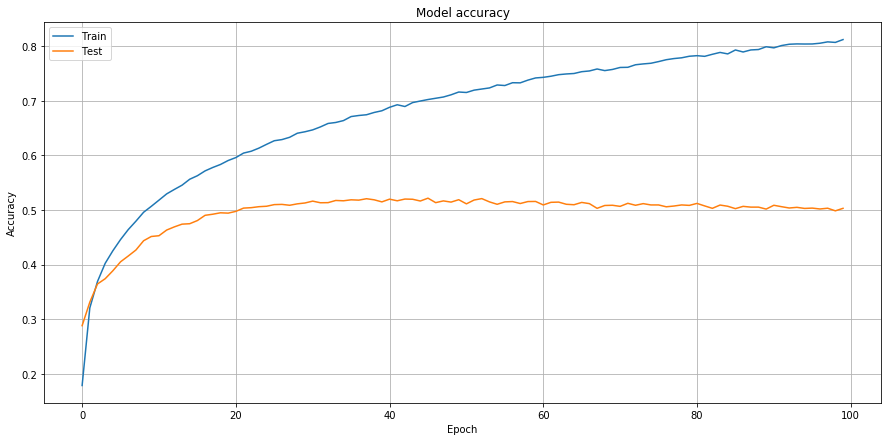

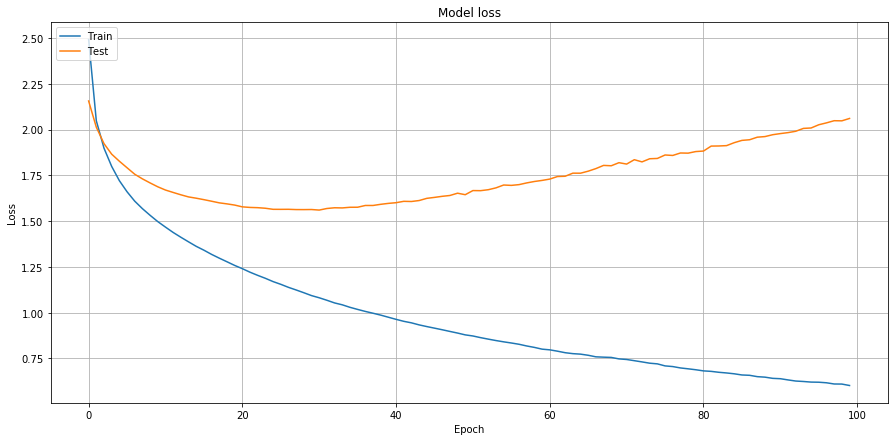

In [108]:
basic_model = create_model((100, 100))
print_history(fit_model(basic_model))

Заметно что модель переобучается. Для этого будем использовать параметр регуляризации альфа. Попробуем несколько его значений.

## Альфа = 1

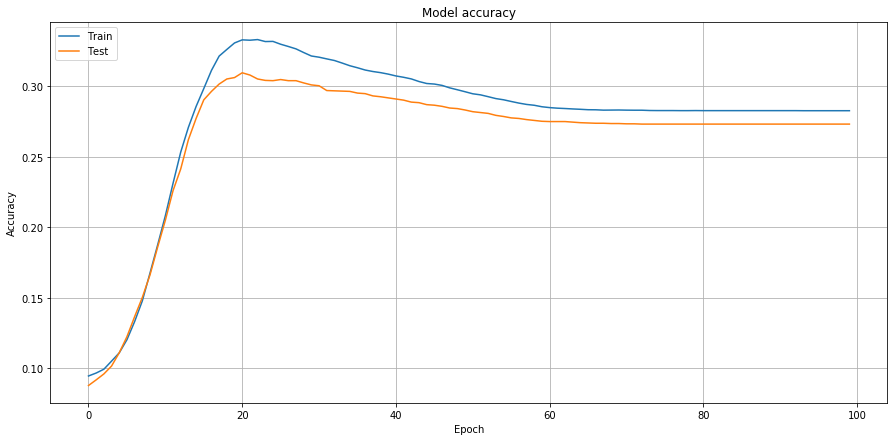

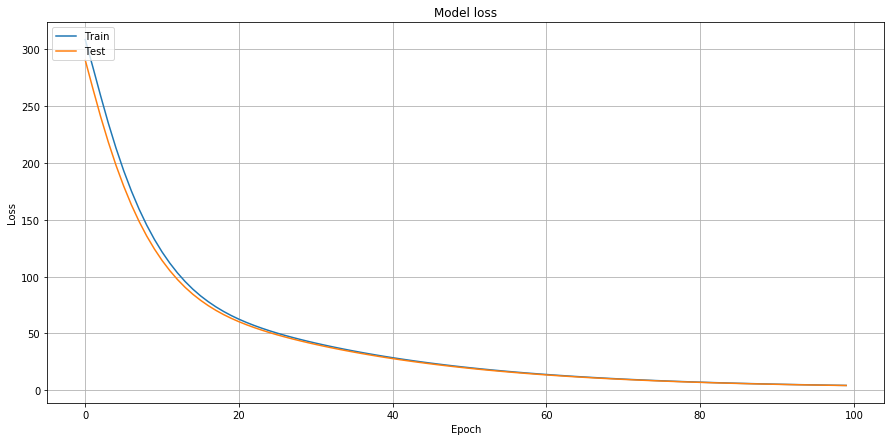

In [109]:
print_history(fit_model(create_model((100, 100), alpha_param=1)))

От переобучения удалось избавиться, однако модель получилась слишком "простая" т.е. точность недостаточна. Теперь нужно уменьшать альфа.

## Альфа = 0.1

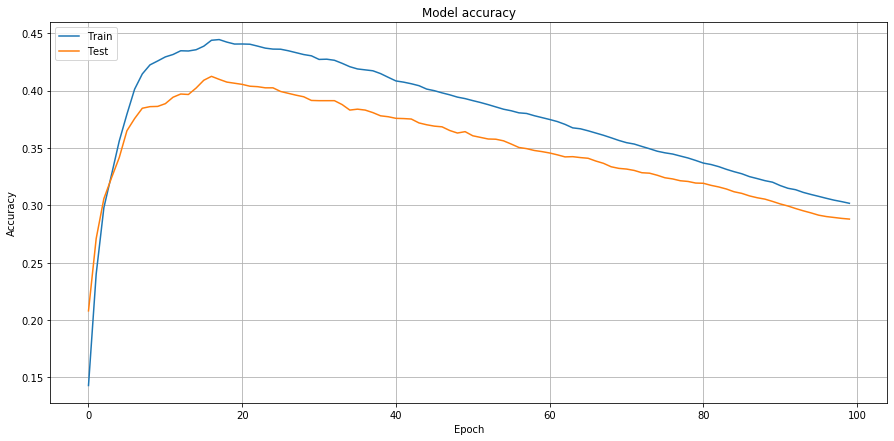

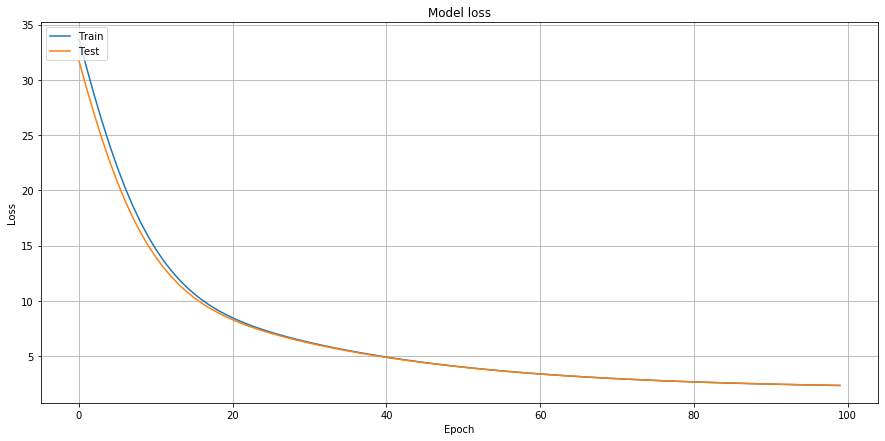

In [112]:
print_history(fit_model(create_model((100, 100), alpha_param=0.1)))

Стало лучше, но похоже, что альфа все еще слишком высокое.

## Альфа = 0.05

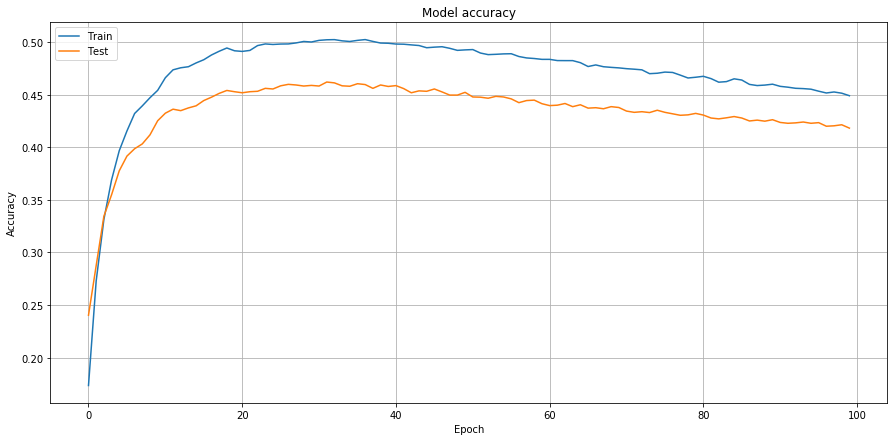

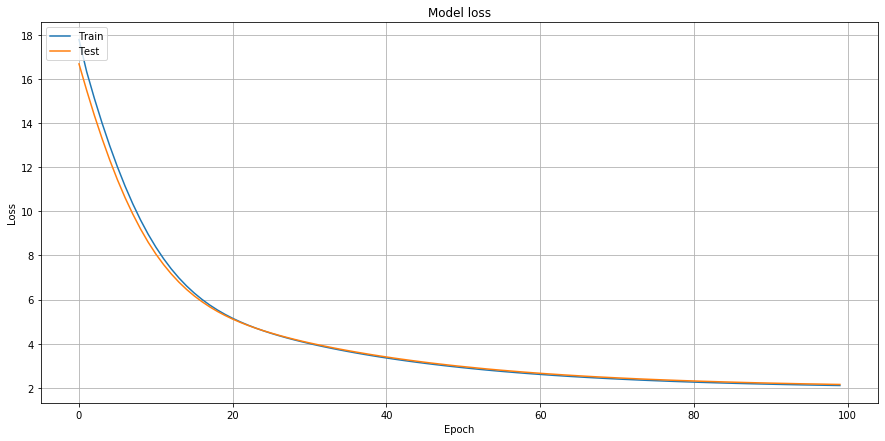

In [113]:
print_history(fit_model(create_model((100, 100), alpha_param=0.05)))

## Подбор "оптимального" альфа

History for alpha = 1


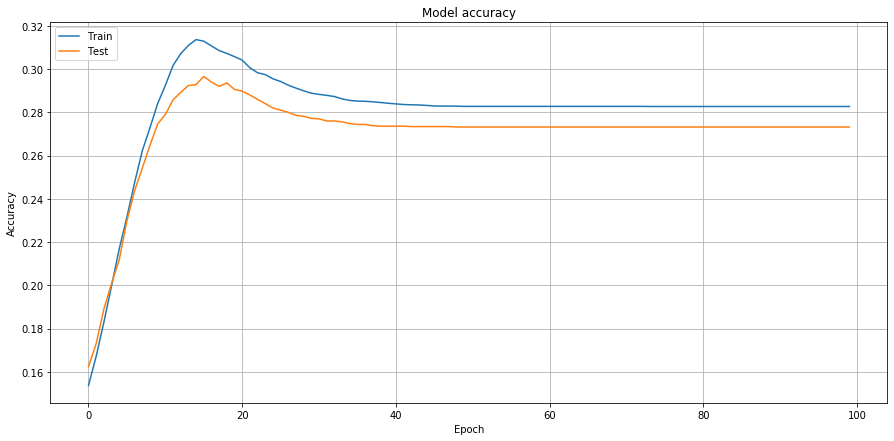

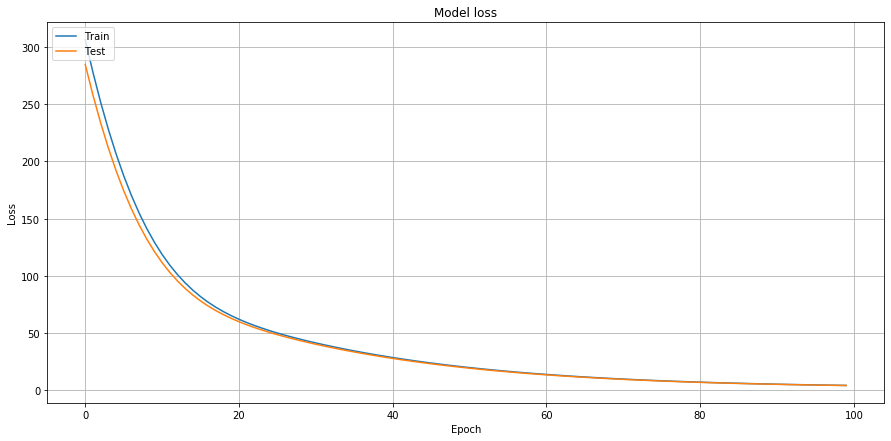

History for alpha = 0.1


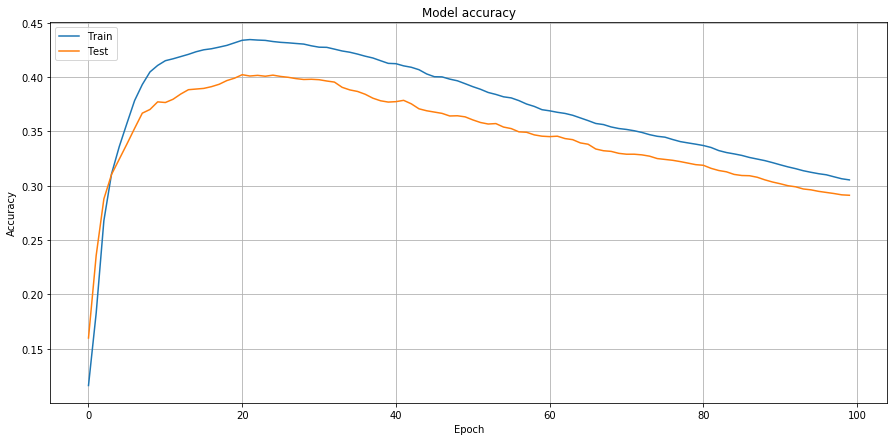

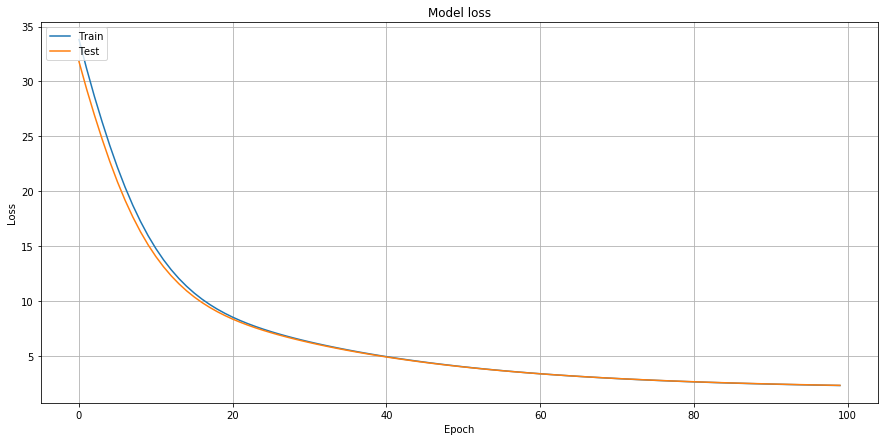

History for alpha = 0.05


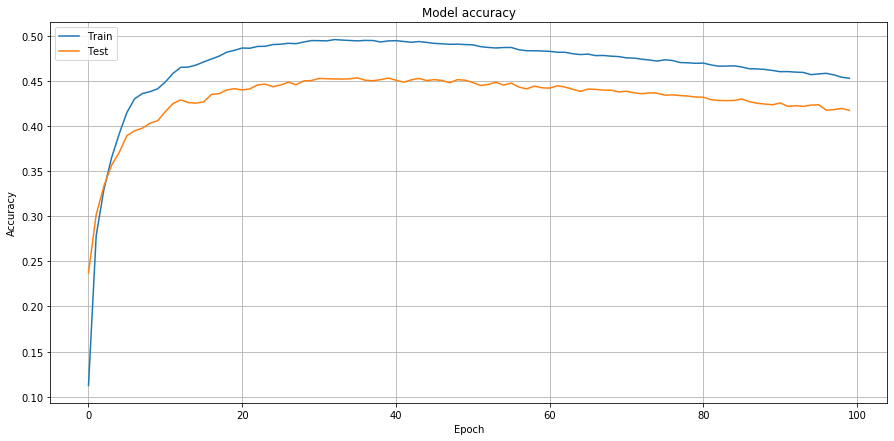

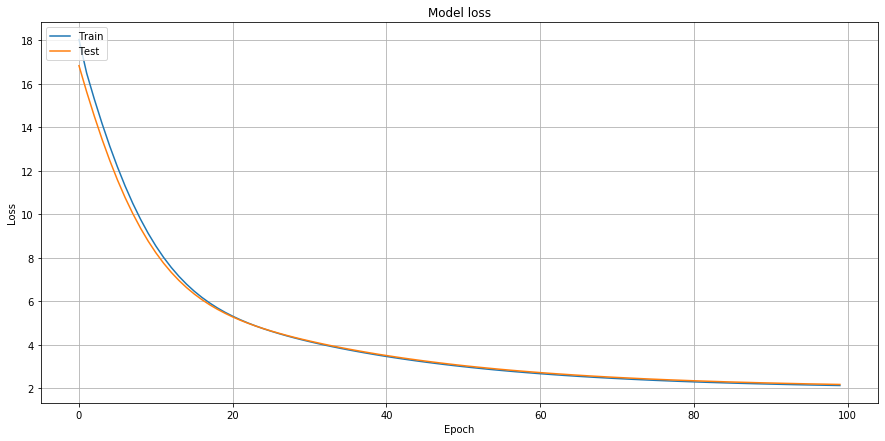

History for alpha = 0.025


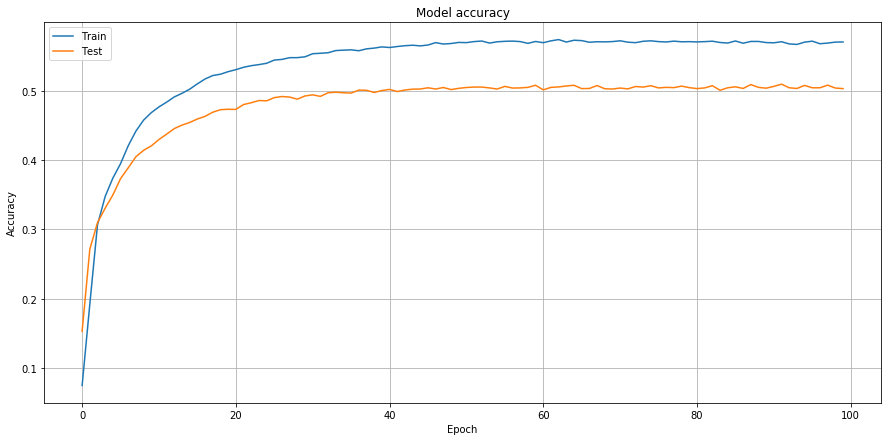

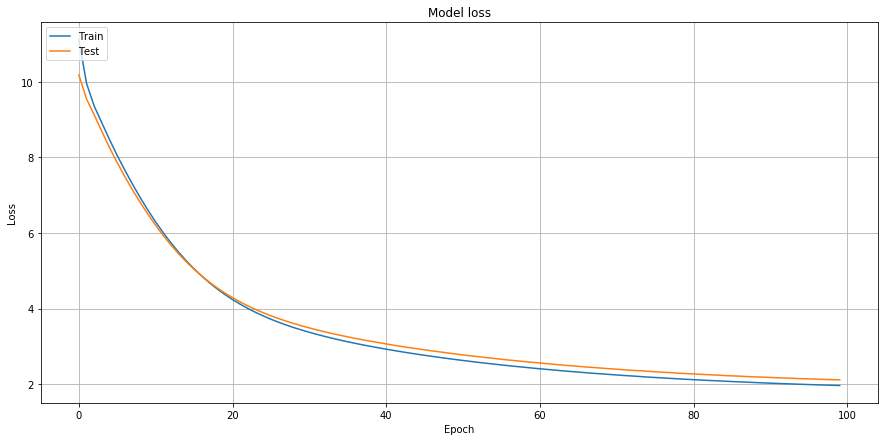

History for alpha = 0.02


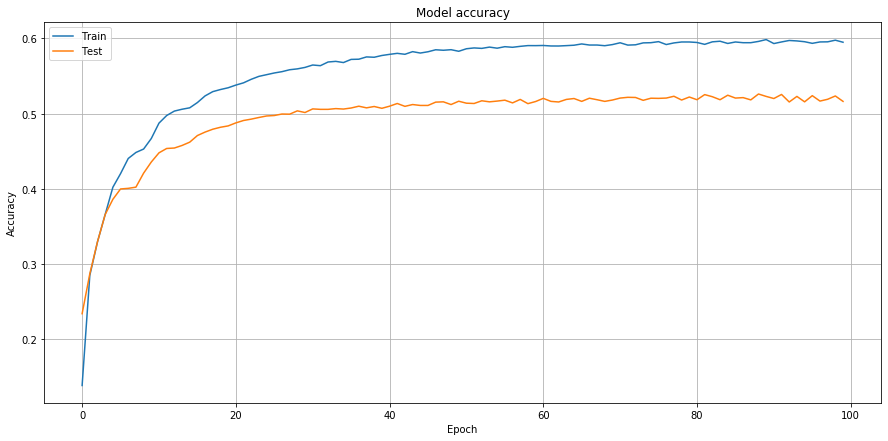

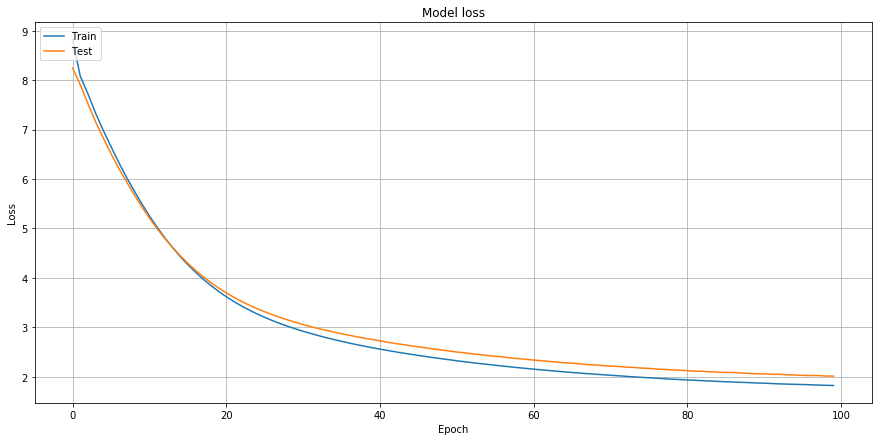

History for alpha = 0.015


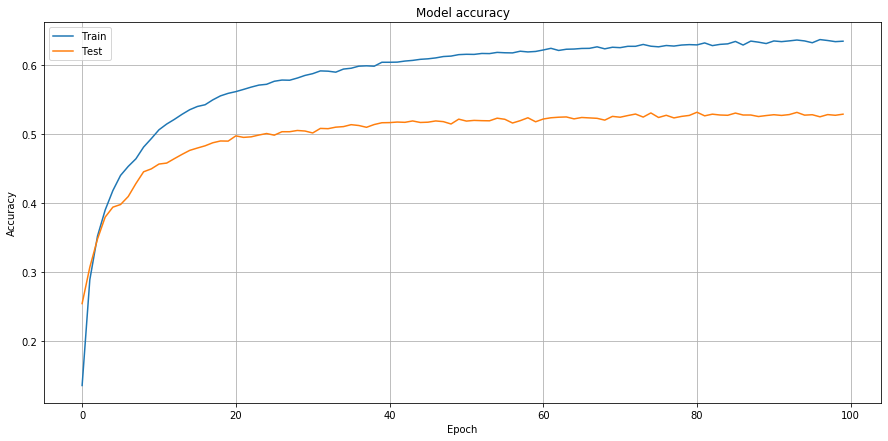

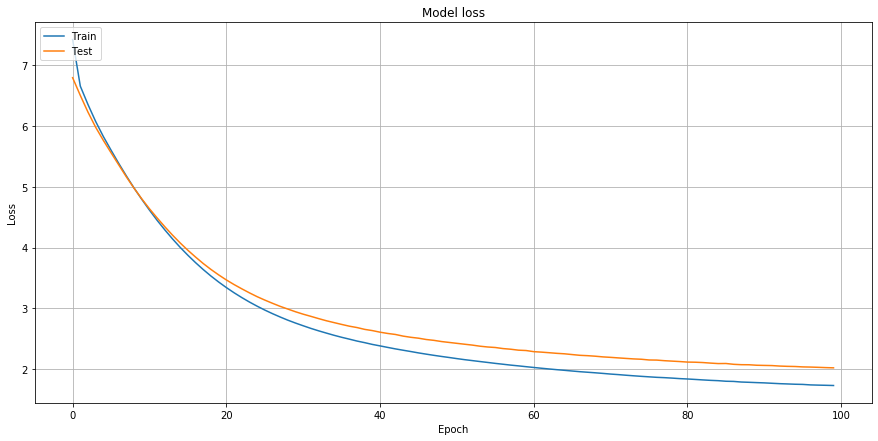

History for alpha = 0.01


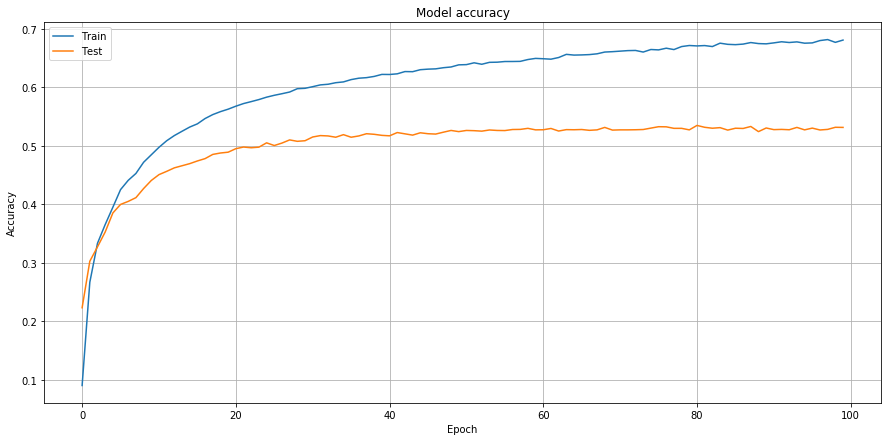

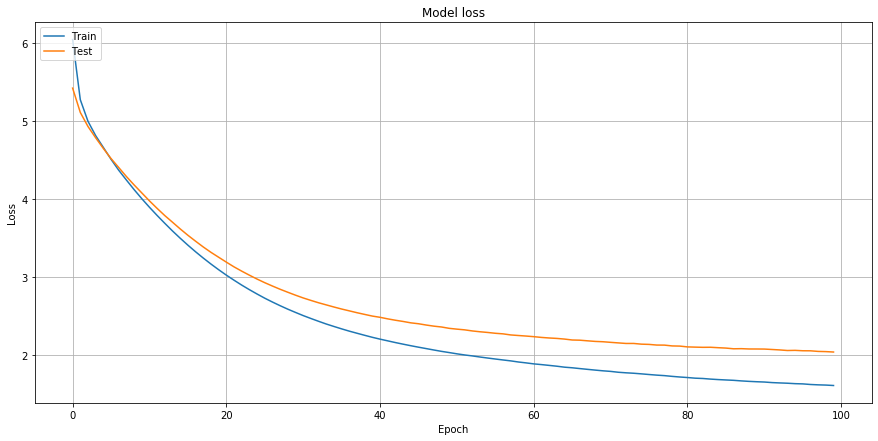

History for alpha = 0.005


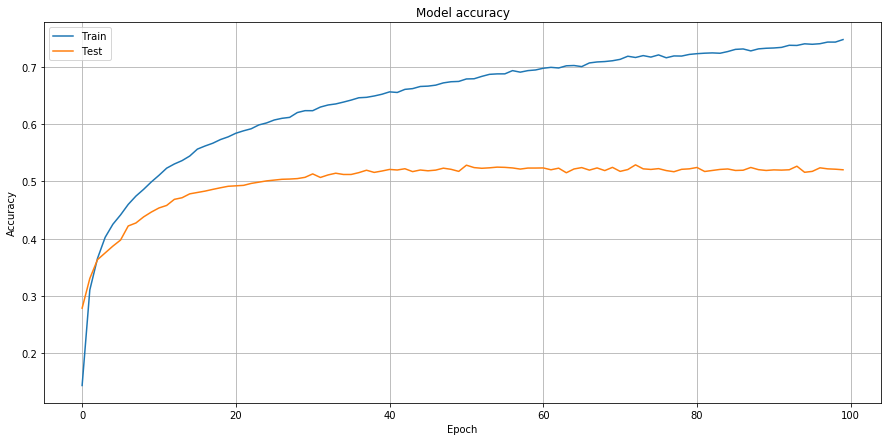

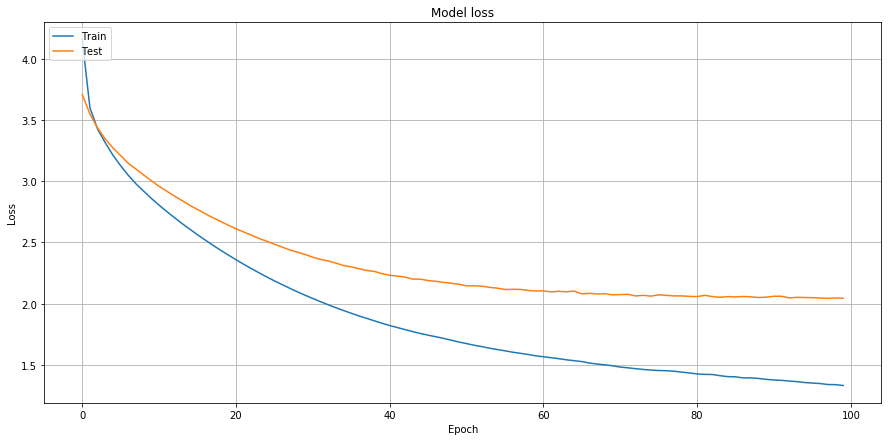

In [123]:
alphas = [1, 0.1, 0.05, 0.025, 0.020, 0.015, 0.010, 0.005]
val_accs = []
accs = []

for alpha in alphas:
  history = fit_model(create_model((100, 100), alpha_param=alpha))
  val_accs.append(history.history['val_acc'][-1])
  accs.append(history.history['acc'][-1])
  print(f'History for alpha = {alpha}')
  print_history(history)


Проанализируем полученные значения

In [126]:
overfits = [acc - val_acc for acc, val_acc in zip(accs, val_accs)]
for alpha, acc, val_acc, overfit in zip(alphas, accs, val_accs, overfits):
  print(f'Alpha={alpha}. Acc = {round(acc * 100, 2)}%. Val_acc = {round(val_acc * 100, 2)}%. Overfit = {round(overfit * 100, 4)}%')

Alpha=1. Acc = 28.27%. Val_acc = 27.32%. Overfit = 0.95%
Alpha=0.1. Acc = 30.54%. Val_acc = 29.12%. Overfit = 1.415%
Alpha=0.05. Acc = 45.28%. Val_acc = 41.72%. Overfit = 3.56%
Alpha=0.025. Acc = 57.03%. Val_acc = 50.3%. Overfit = 6.725%
Alpha=0.02. Acc = 59.5%. Val_acc = 51.64%. Overfit = 7.86%
Alpha=0.015. Acc = 63.41%. Val_acc = 52.84%. Overfit = 10.565%
Alpha=0.01. Acc = 68.11%. Val_acc = 53.16%. Overfit = 14.945%
Alpha=0.005. Acc = 74.73%. Val_acc = 52.02%. Overfit = 22.71%


Таким образом оптимальное альфа = 0.02. <br>
При большем альфа наблюдается недостаточная точность. <br>
При меньшем - переобучение увеличивается, при примерно той же точности

## Подбор "оптимального" числа нейронов с заданным альфа

History for neurons = (30, 30)


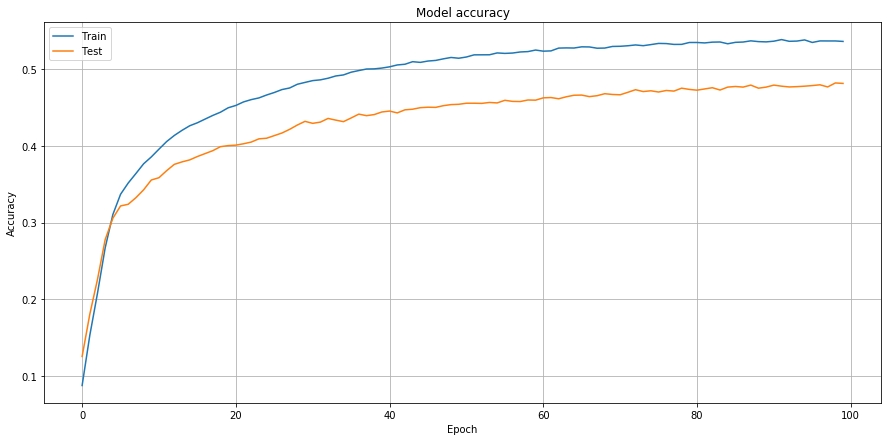

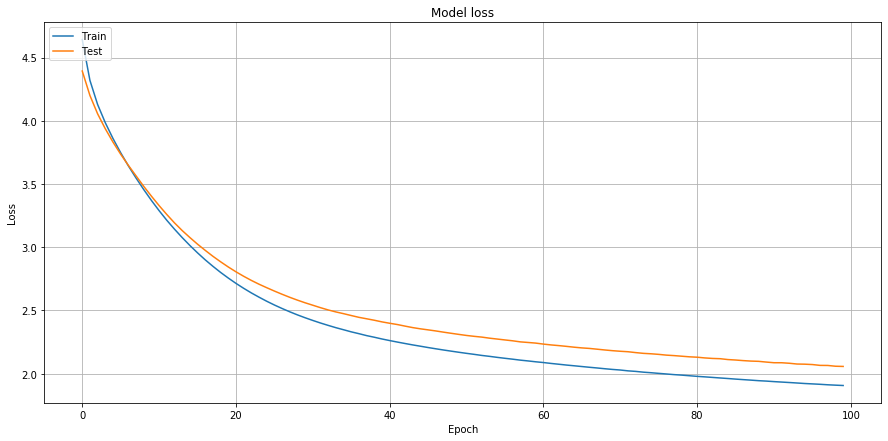

History for neurons = (30, 60)


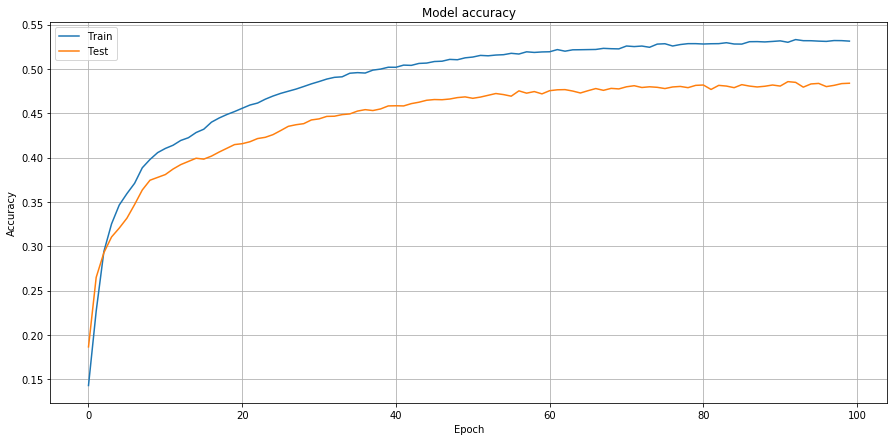

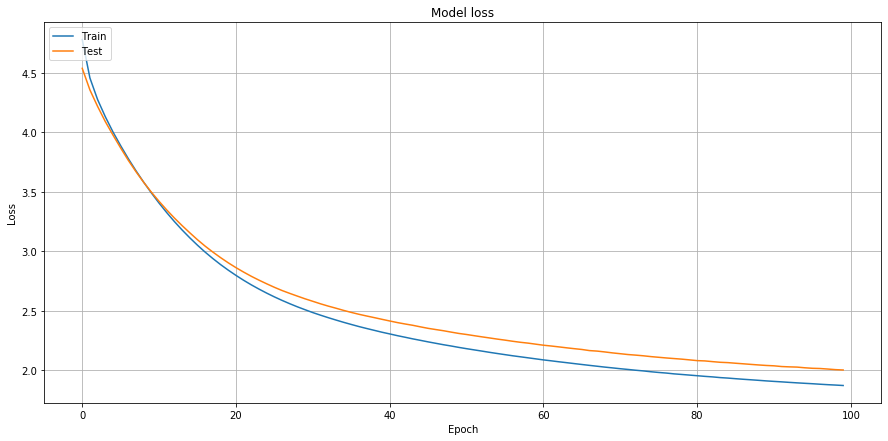

History for neurons = (30, 90)


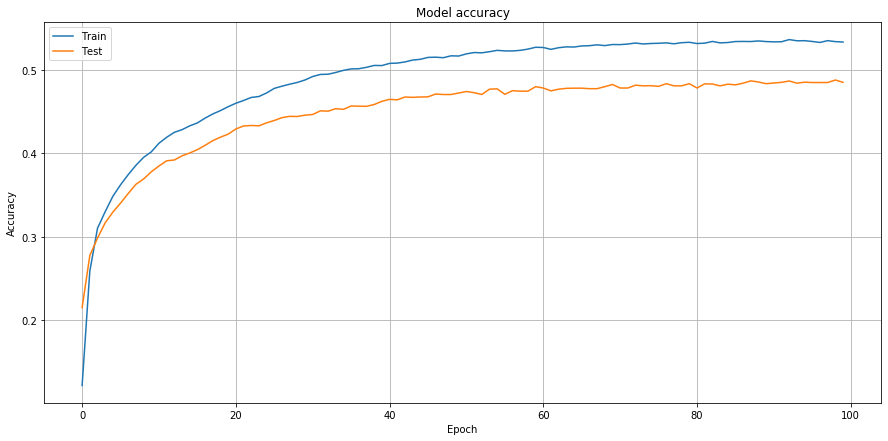

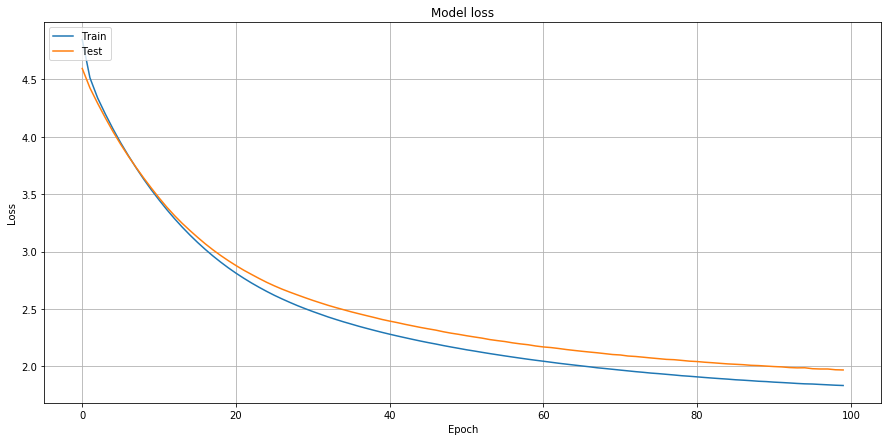

History for neurons = (30, 120)


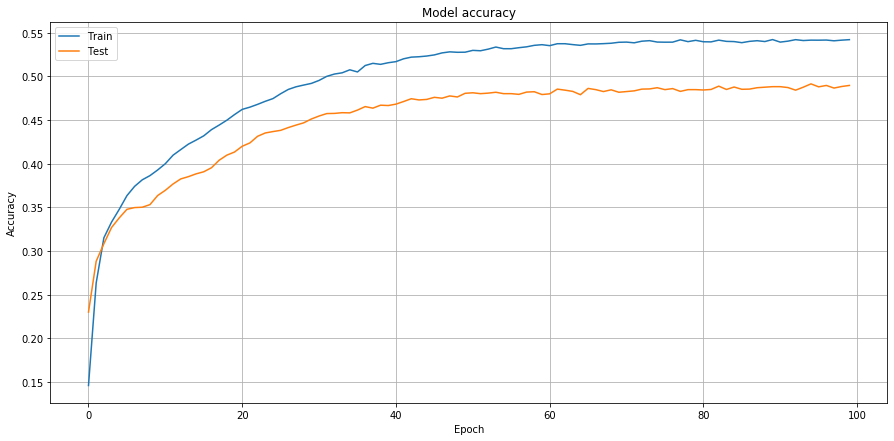

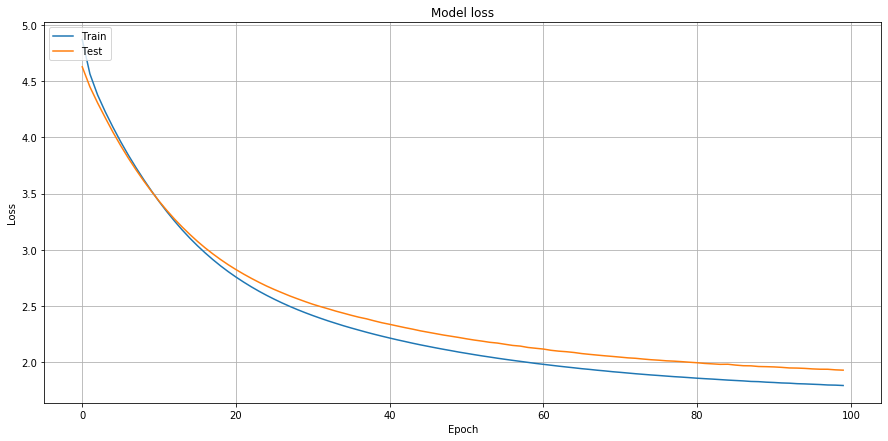

History for neurons = (30, 150)


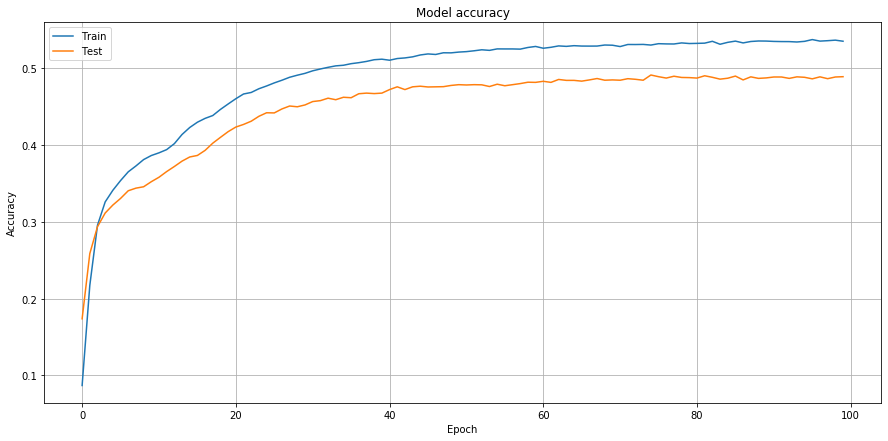

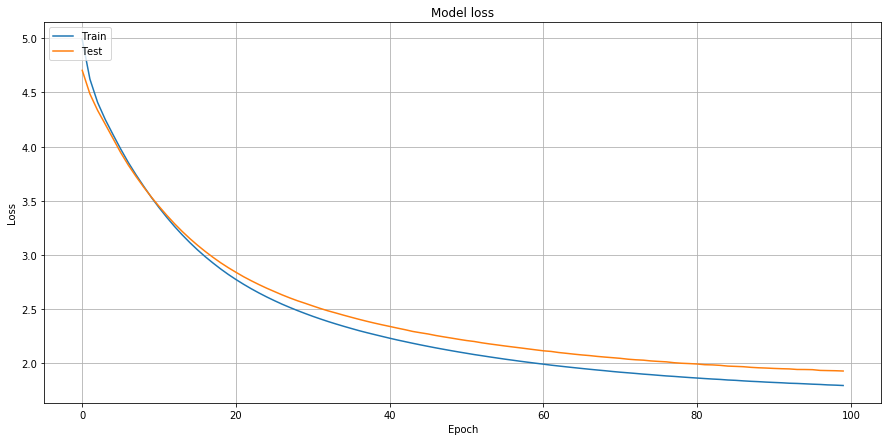

History for neurons = (30, 180)


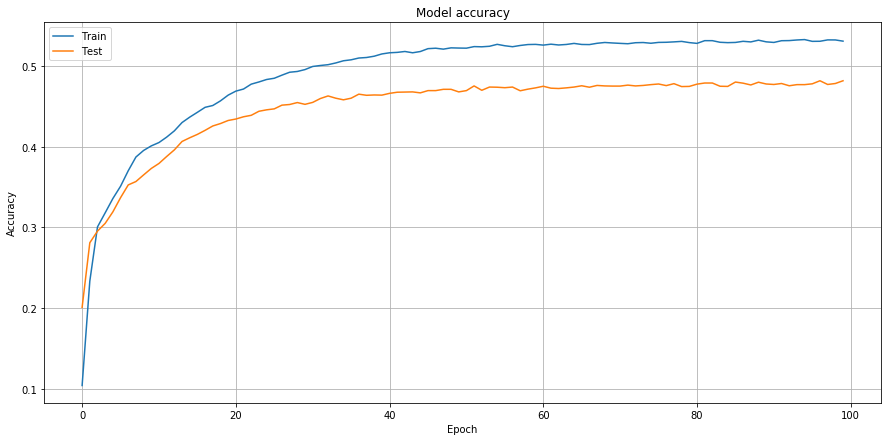

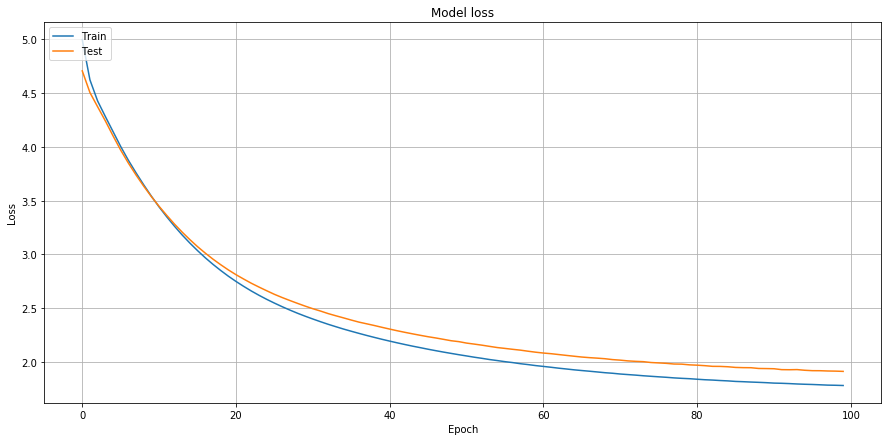

History for neurons = (60, 30)


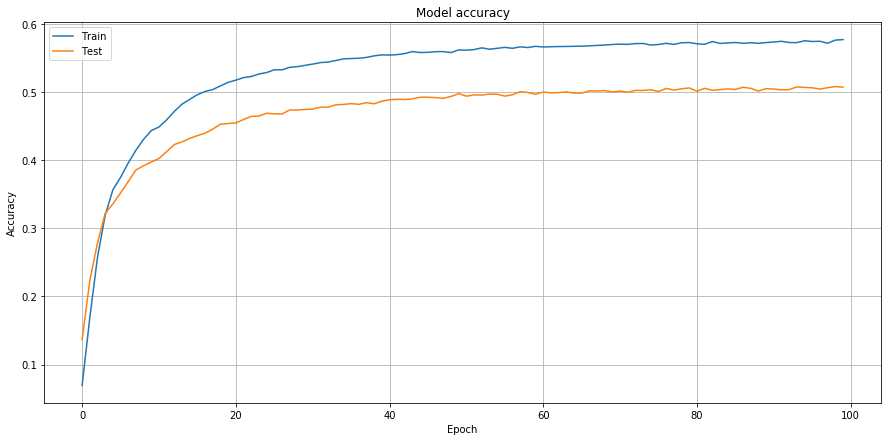

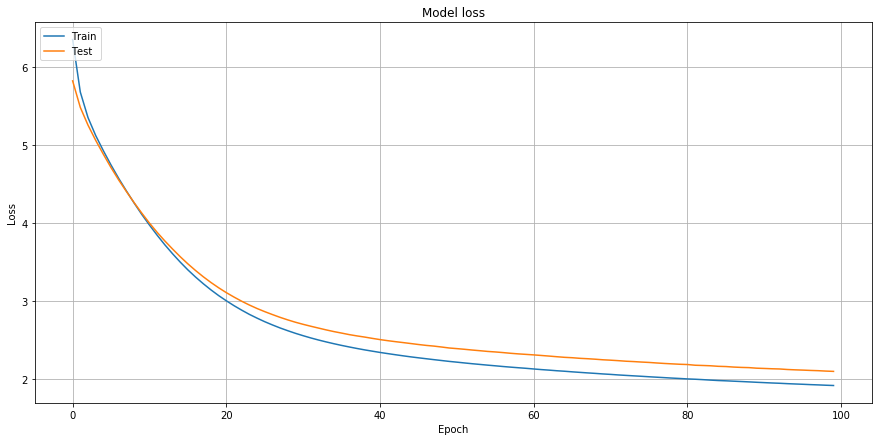

History for neurons = (60, 60)


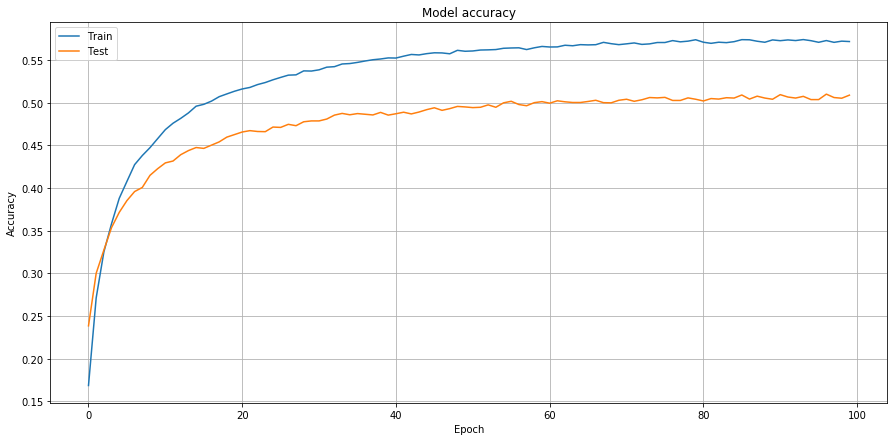

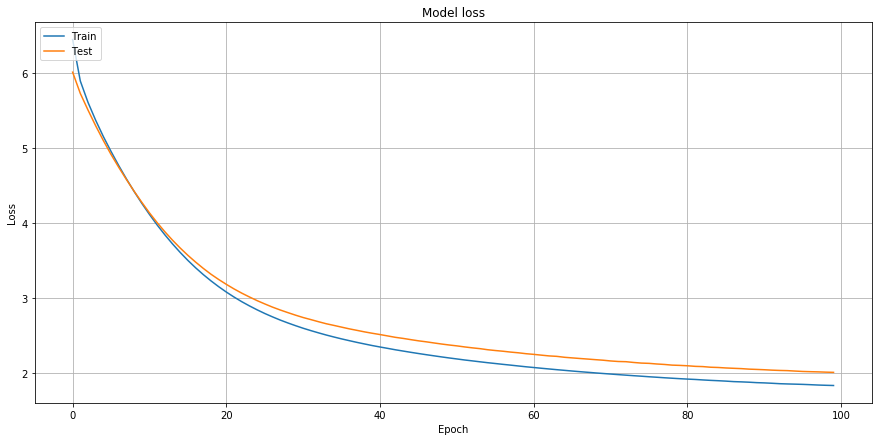

History for neurons = (60, 90)


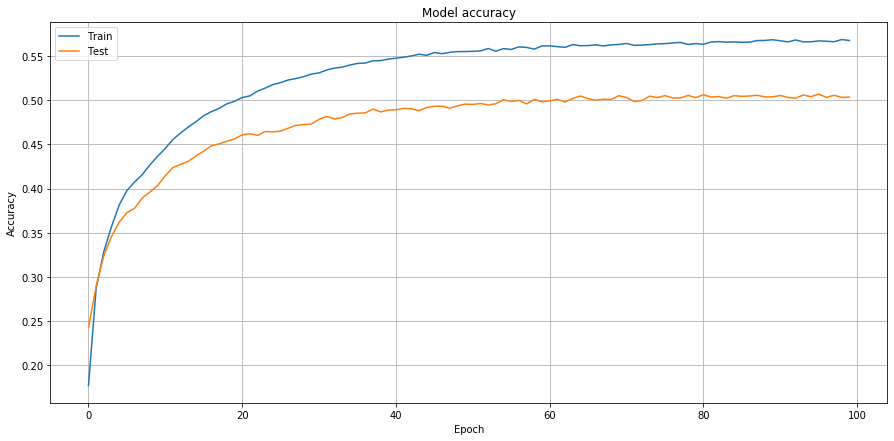

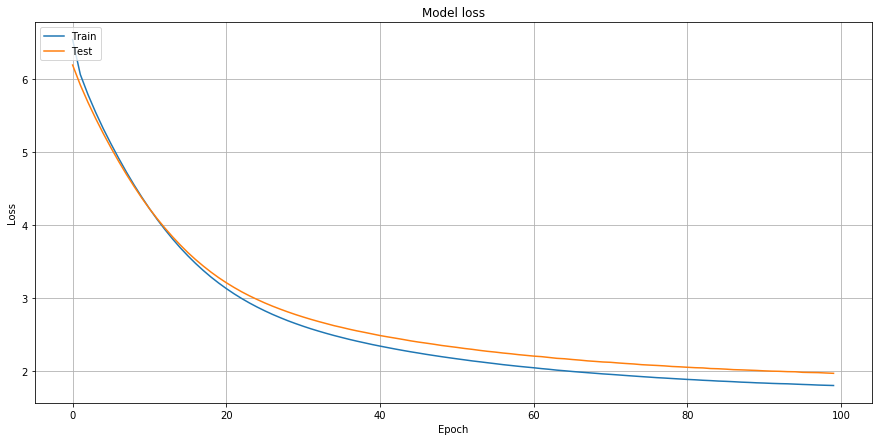

History for neurons = (60, 120)


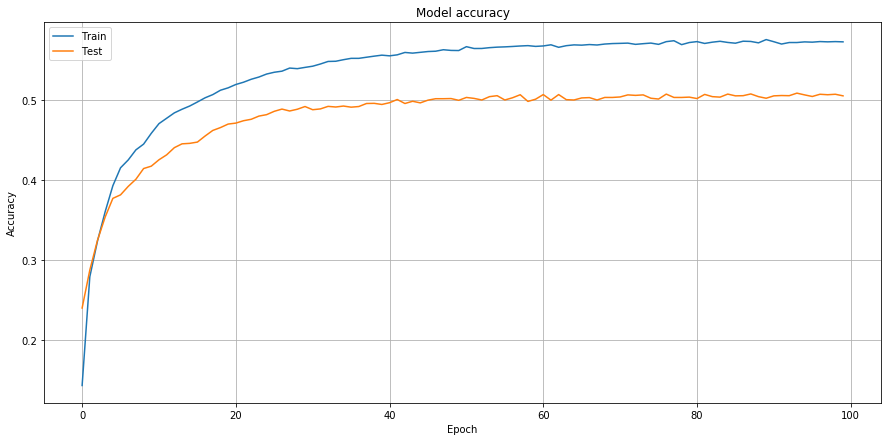

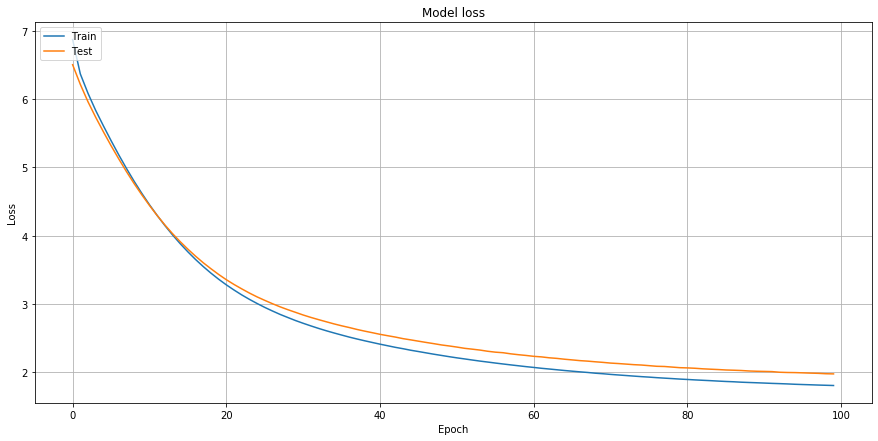

History for neurons = (60, 150)


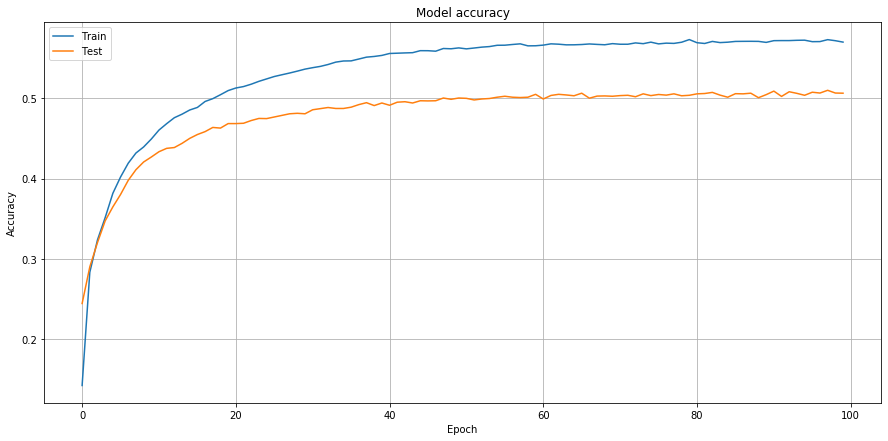

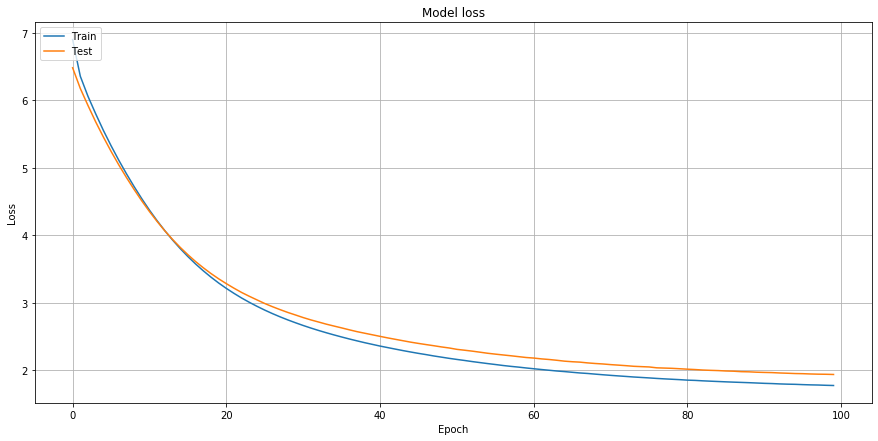

History for neurons = (60, 180)


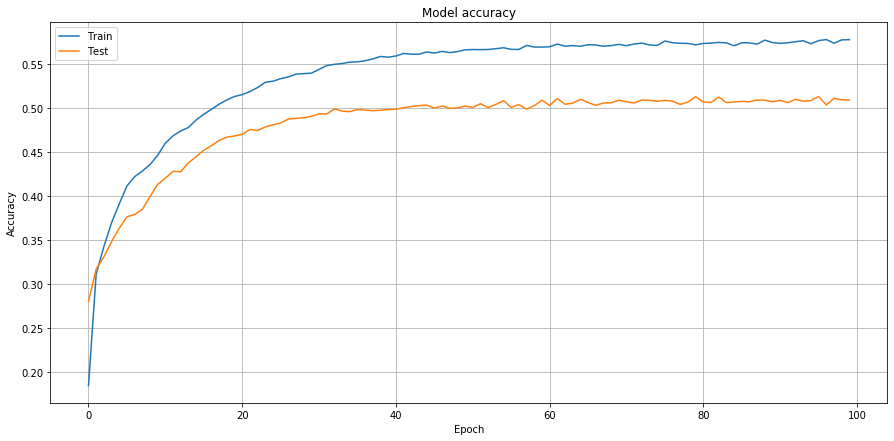

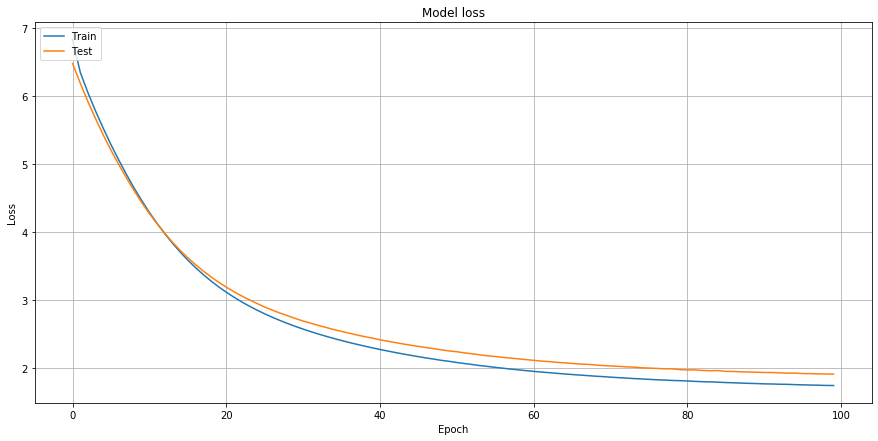

History for neurons = (90, 30)


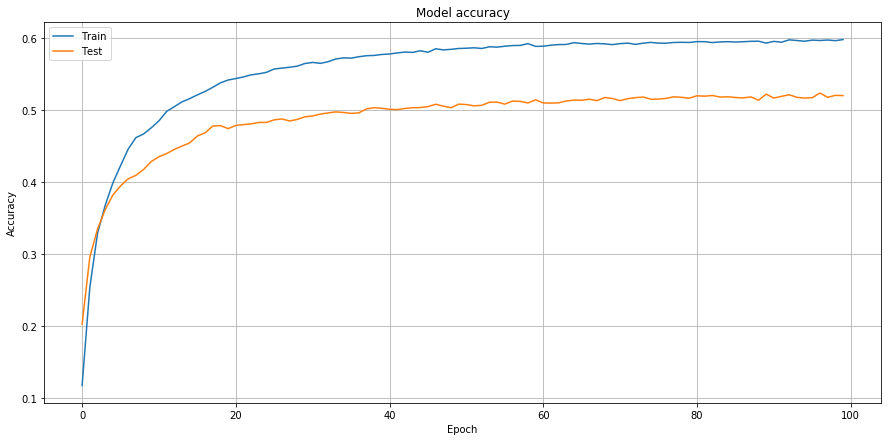

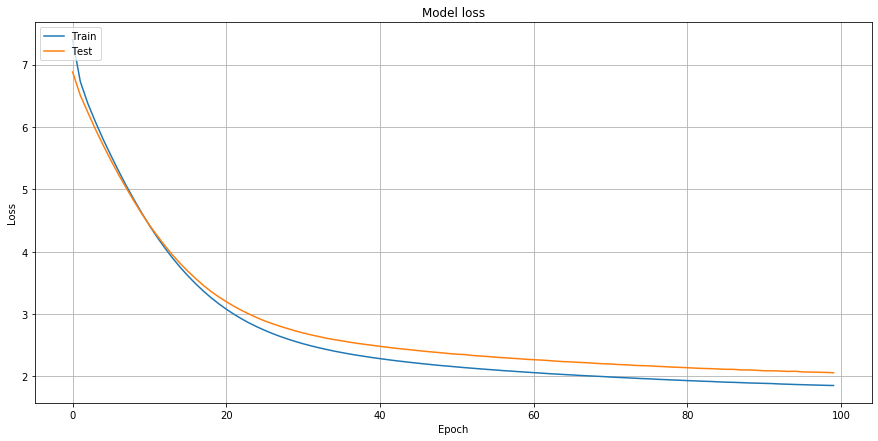

History for neurons = (90, 60)


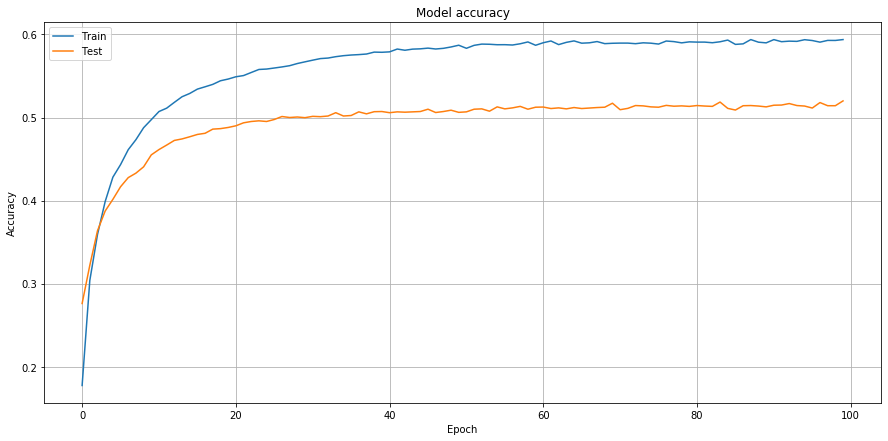

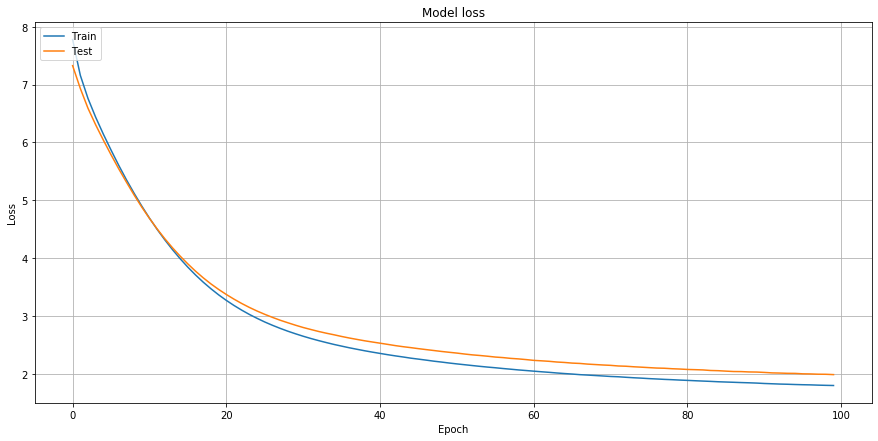

History for neurons = (90, 90)


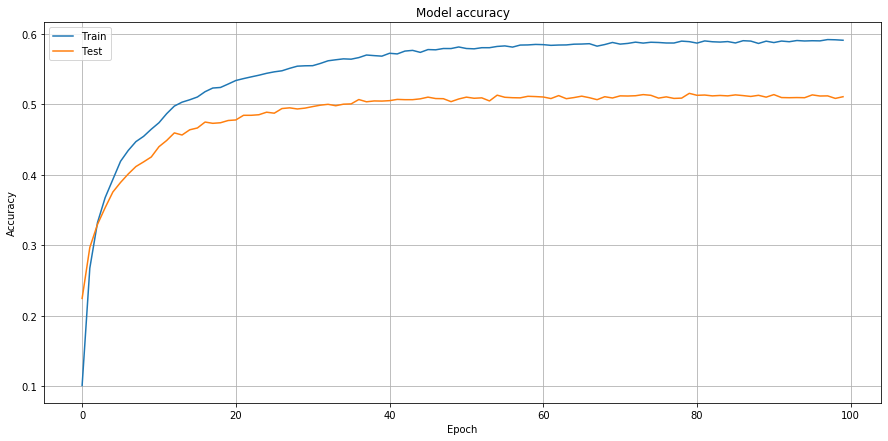

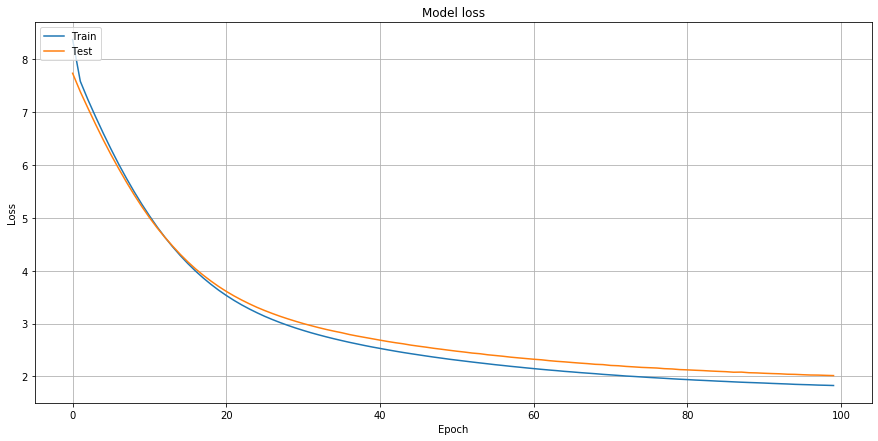

History for neurons = (90, 120)


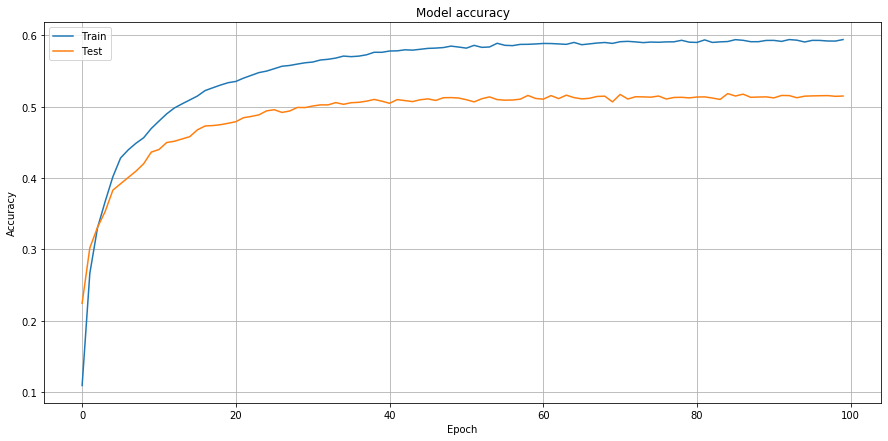

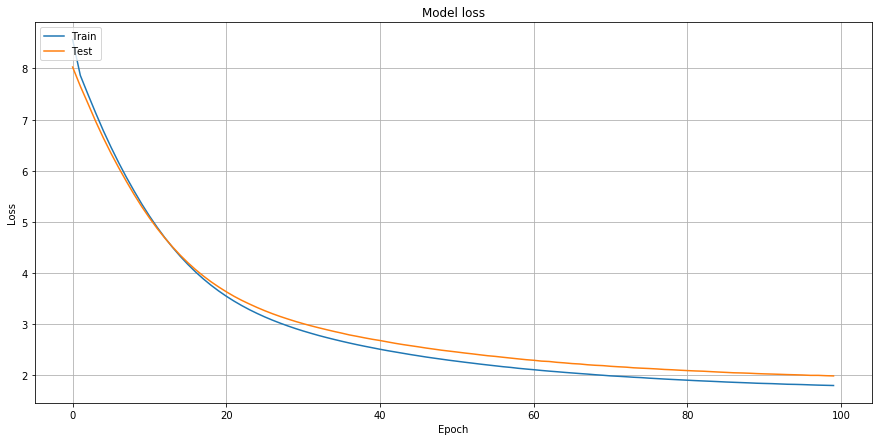

History for neurons = (90, 150)


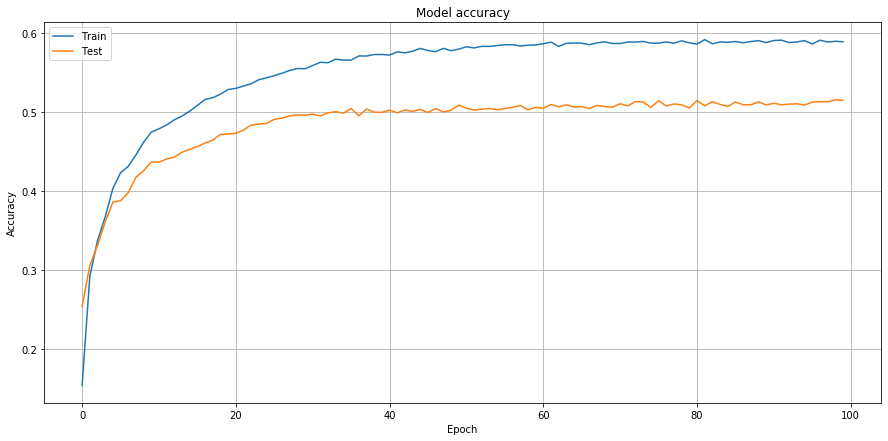

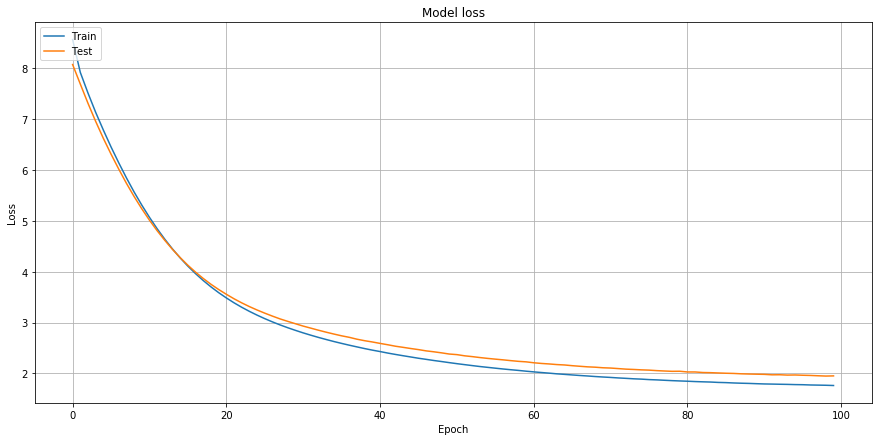

History for neurons = (90, 180)


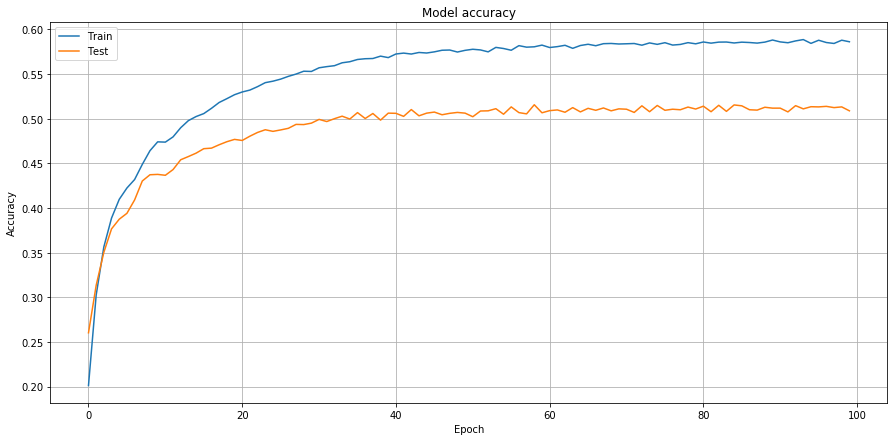

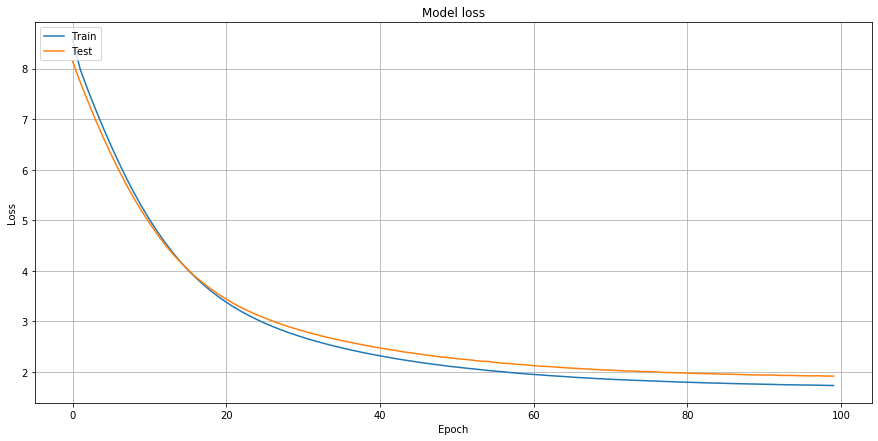

History for neurons = (120, 30)


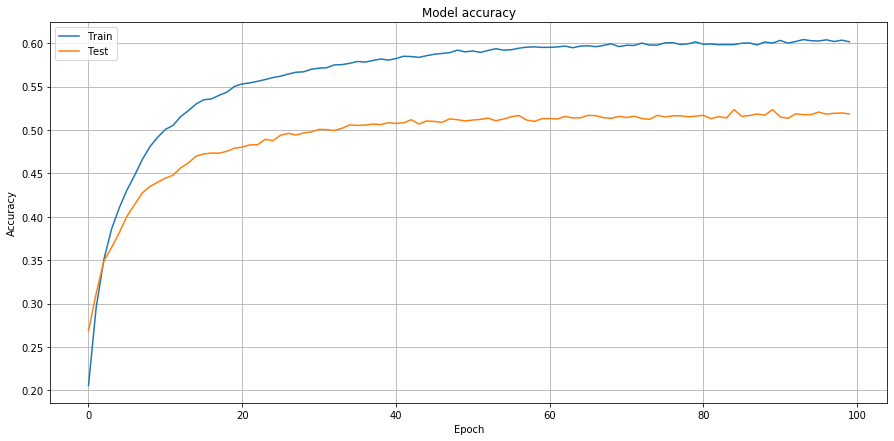

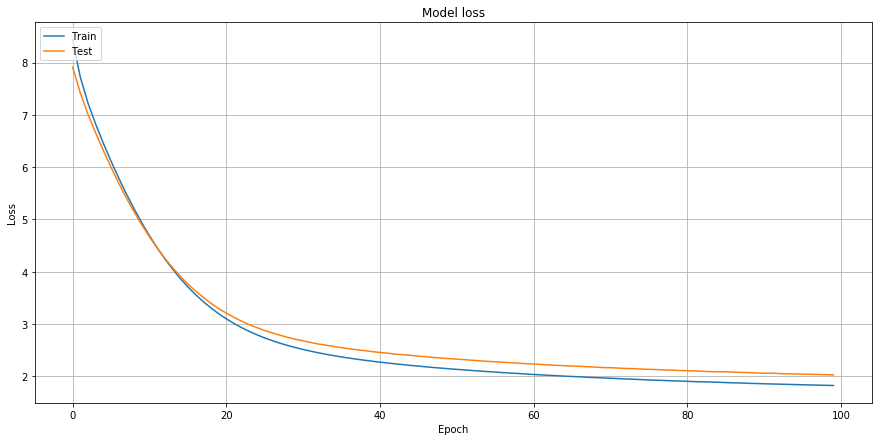

History for neurons = (120, 60)


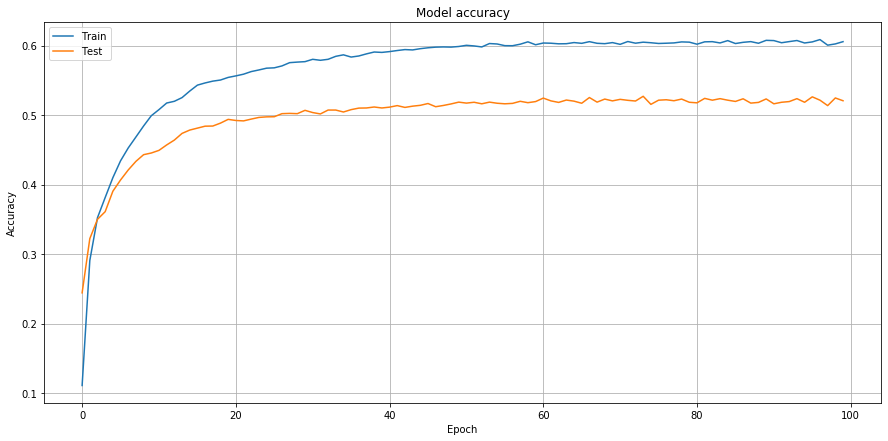

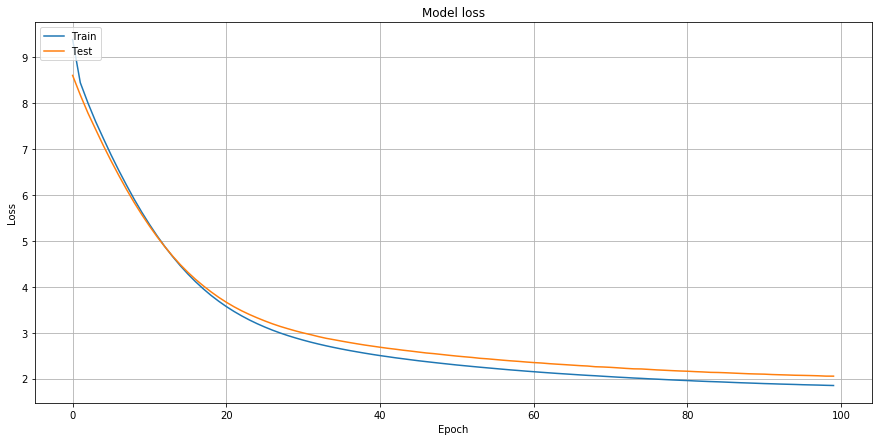

History for neurons = (120, 90)


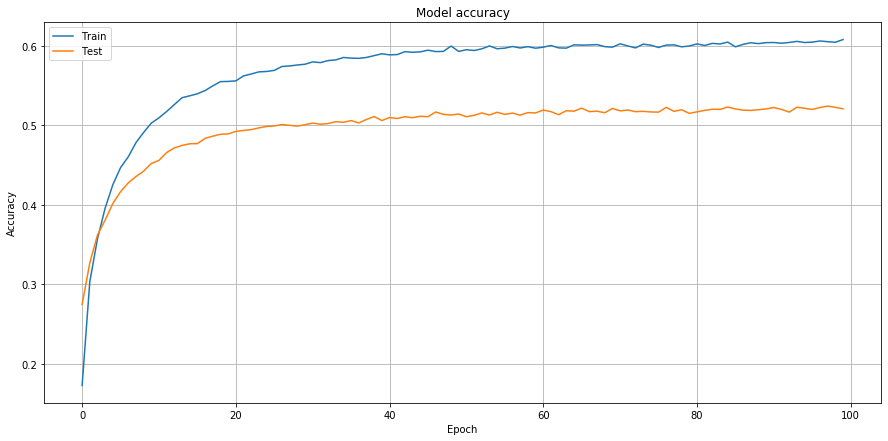

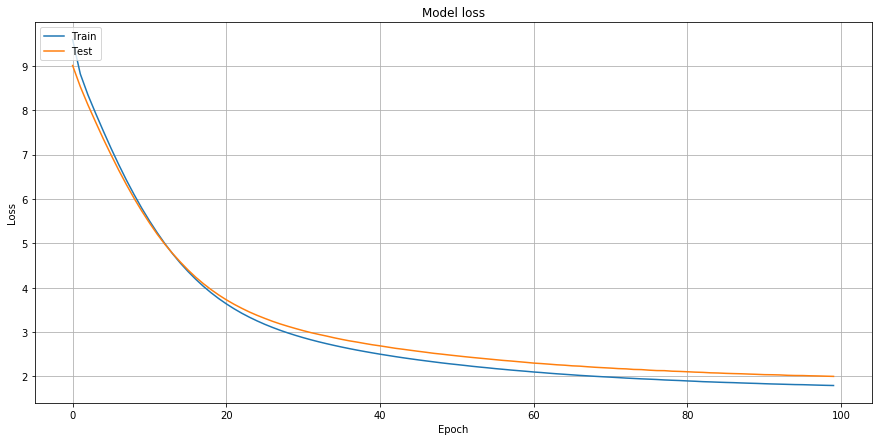

History for neurons = (120, 120)


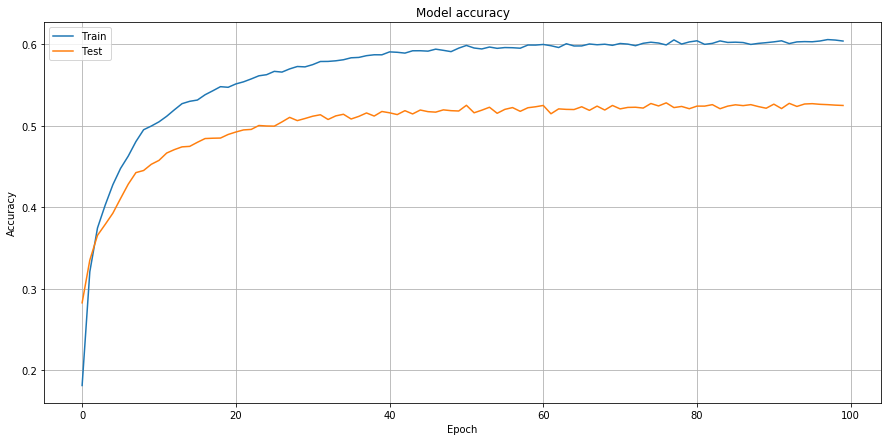

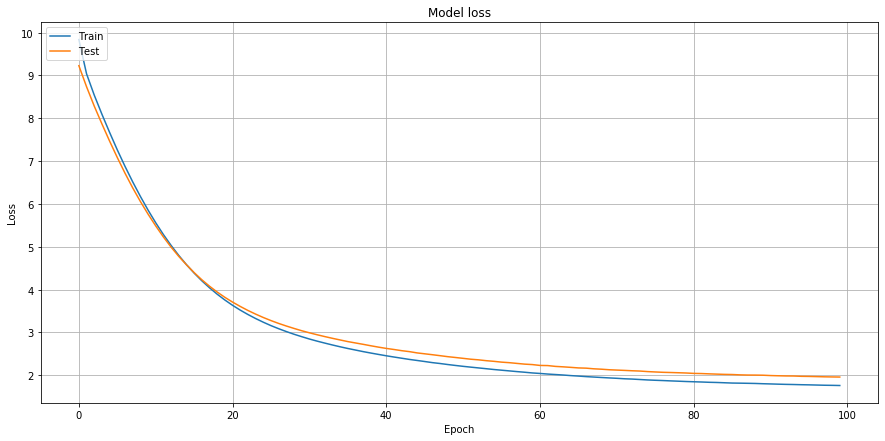

History for neurons = (120, 150)


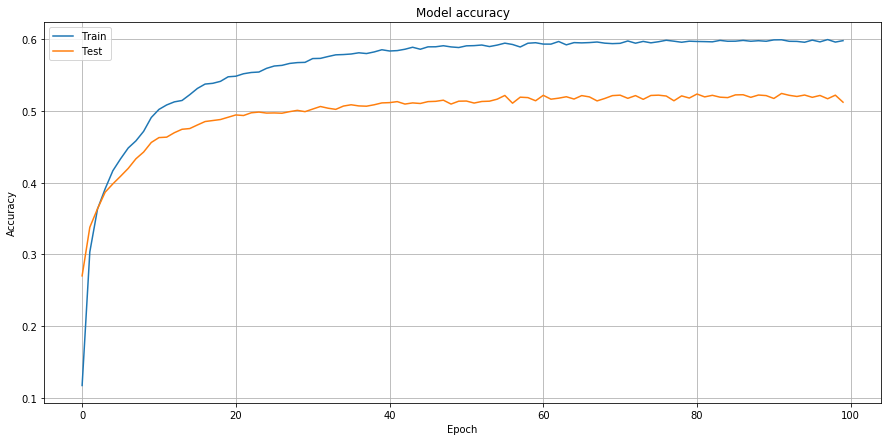

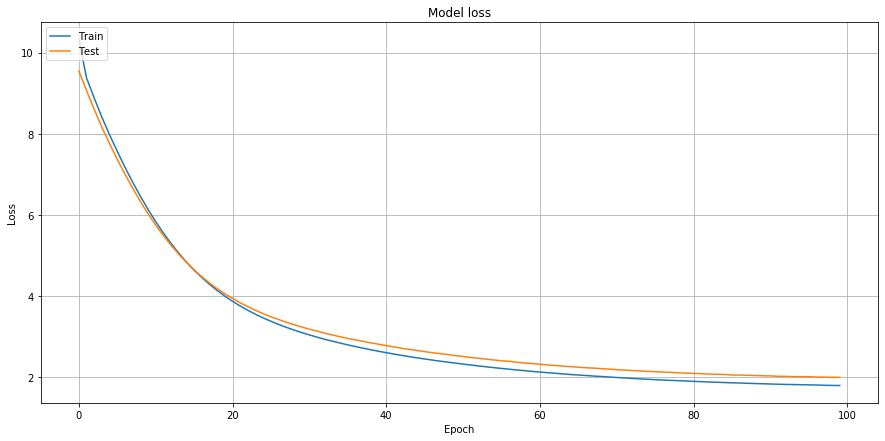

History for neurons = (120, 180)


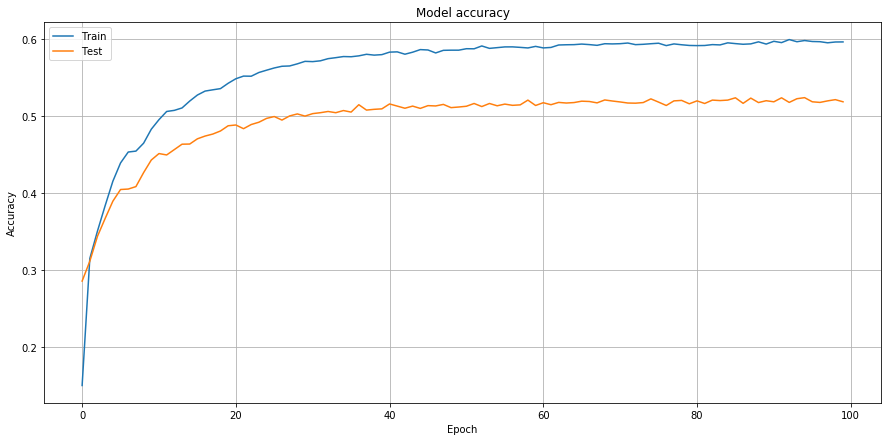

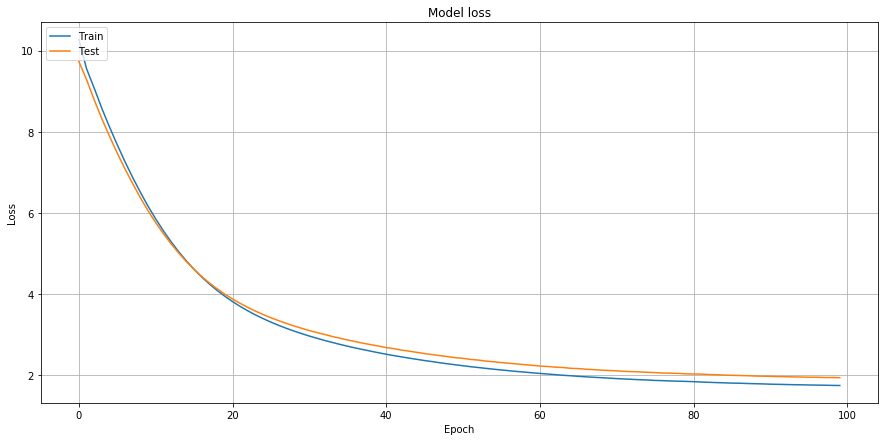

History for neurons = (150, 30)


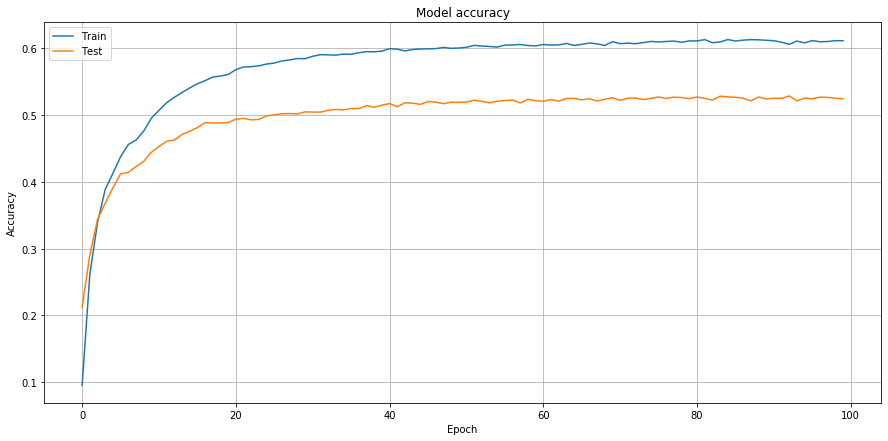

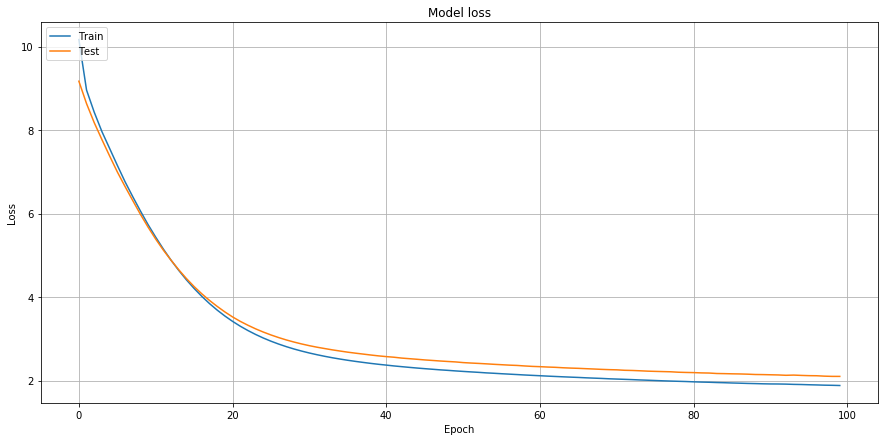

History for neurons = (150, 60)


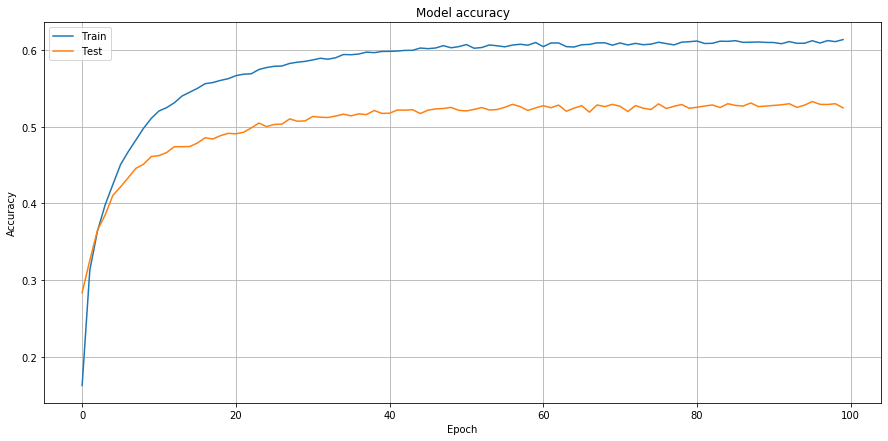

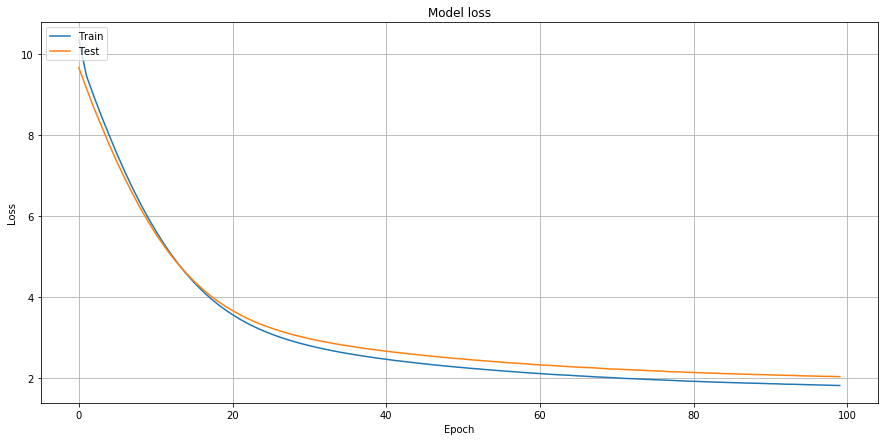

History for neurons = (150, 90)


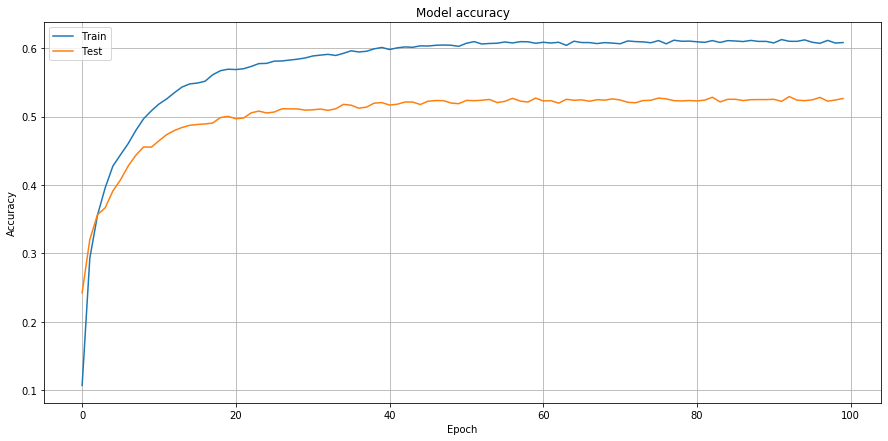

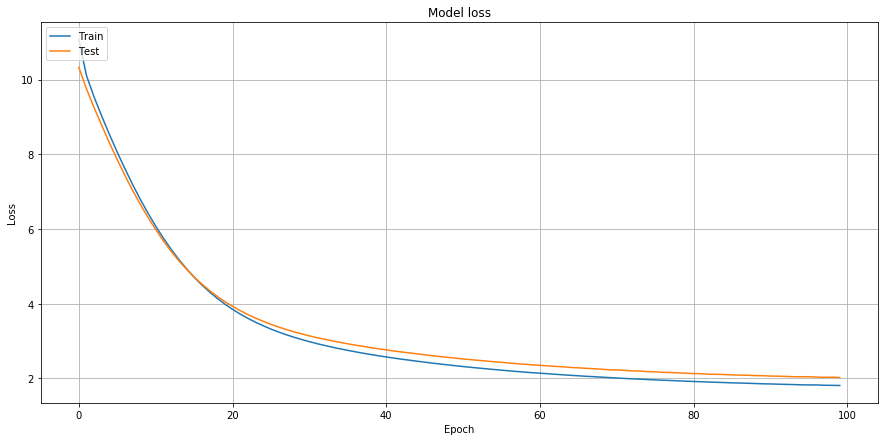

History for neurons = (150, 120)


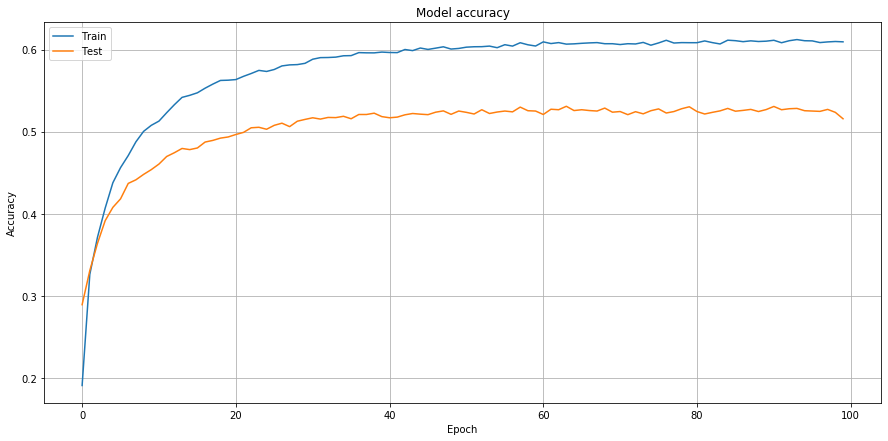

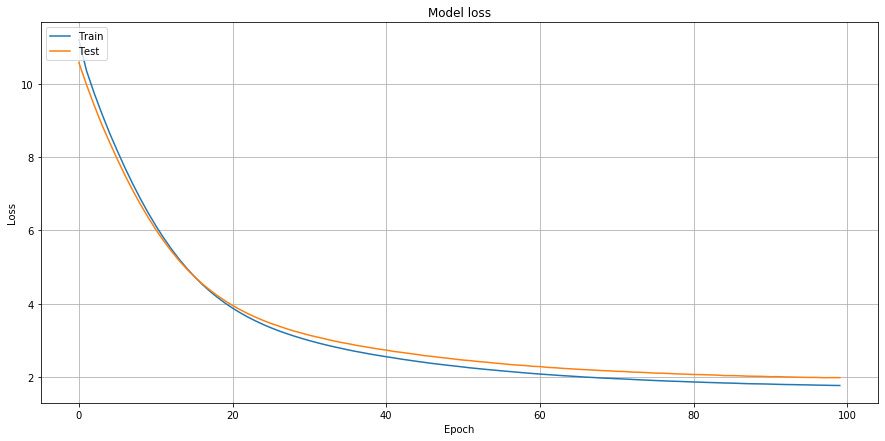

History for neurons = (150, 150)


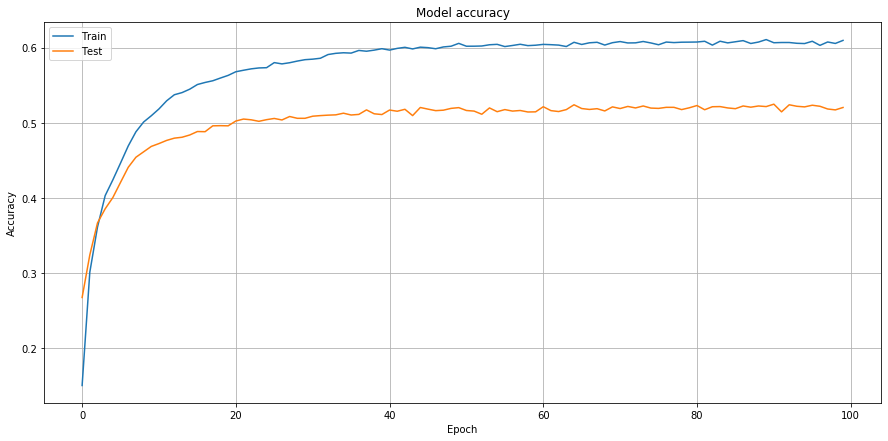

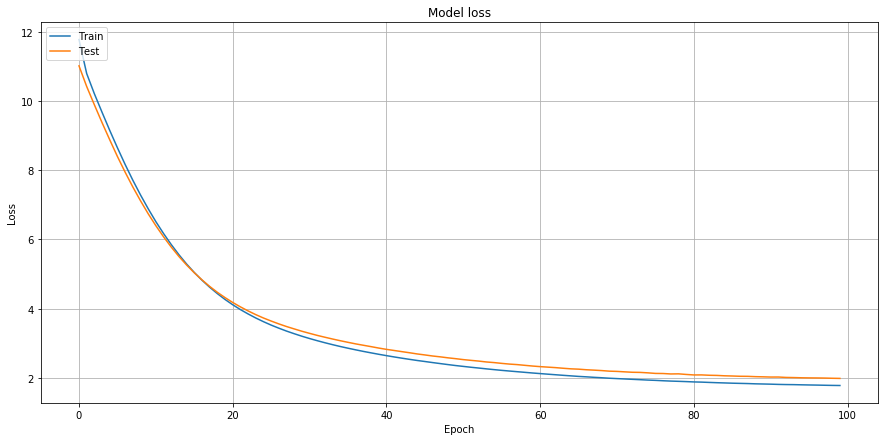

History for neurons = (150, 180)


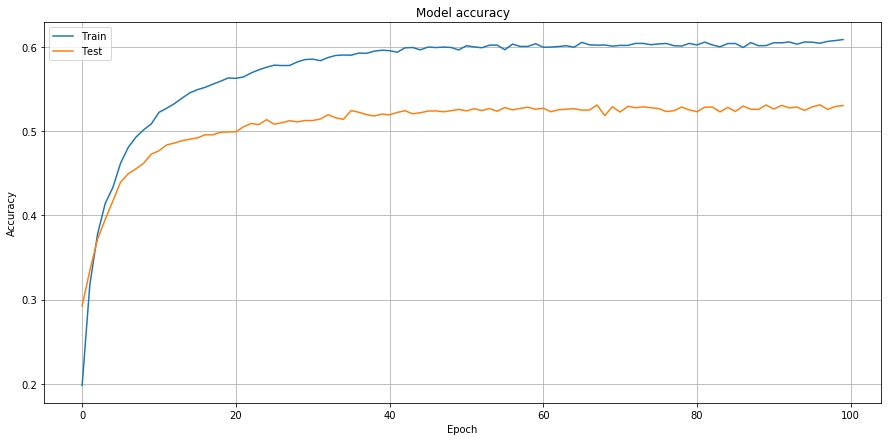

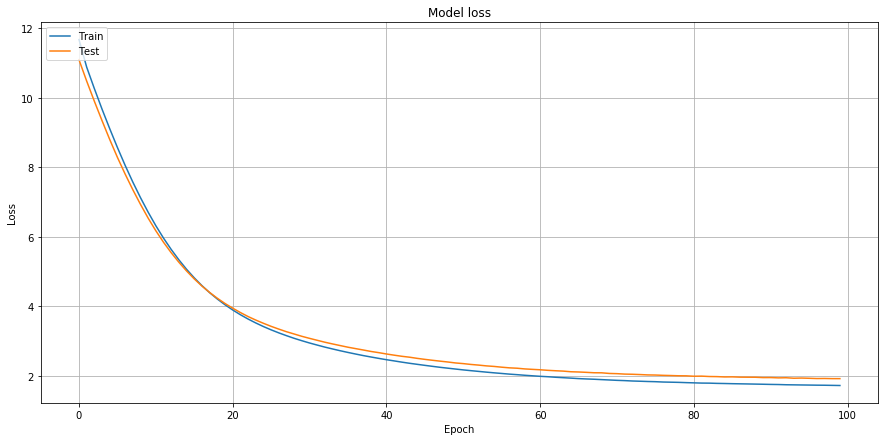

History for neurons = (180, 30)


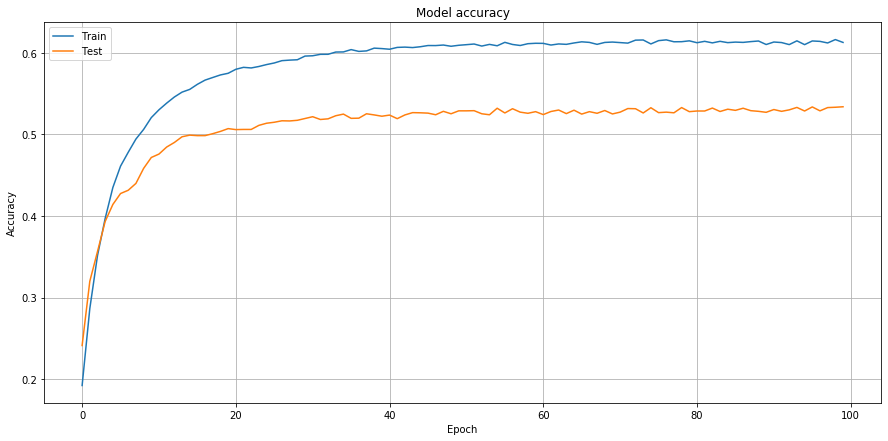

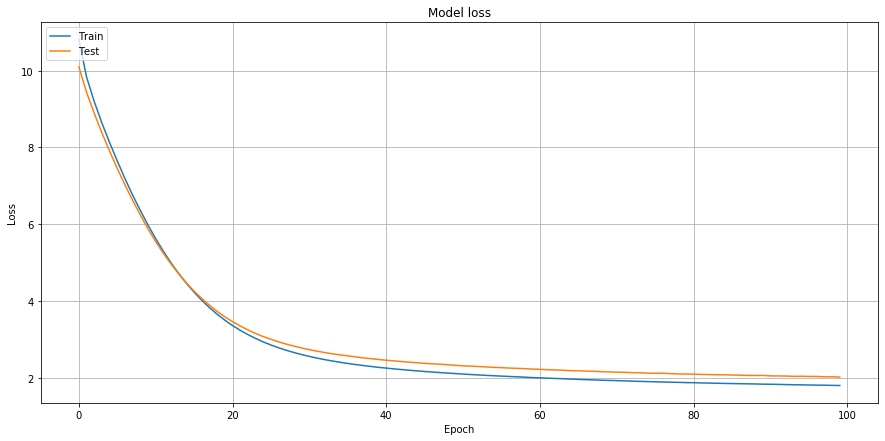

History for neurons = (180, 60)


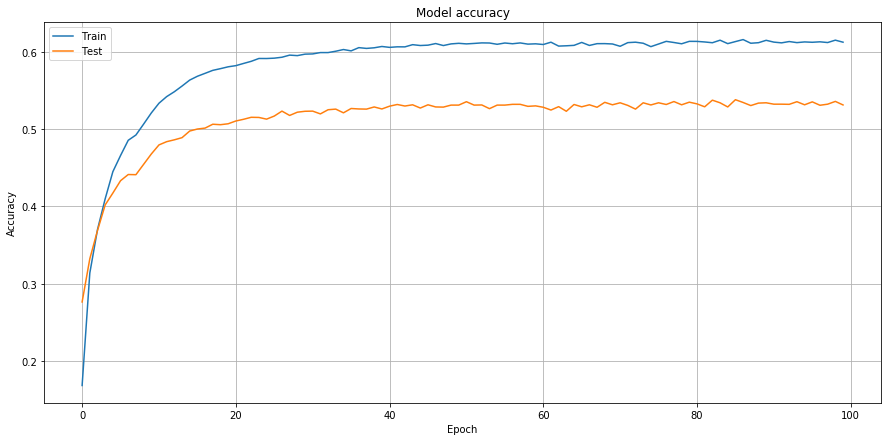

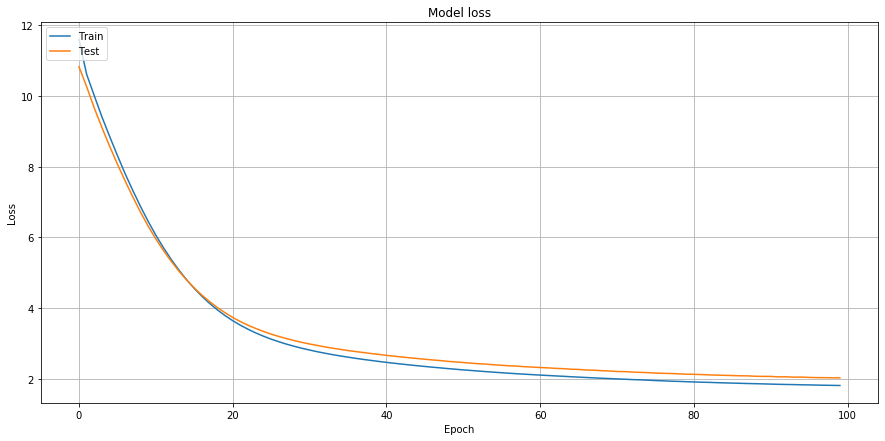

History for neurons = (180, 90)


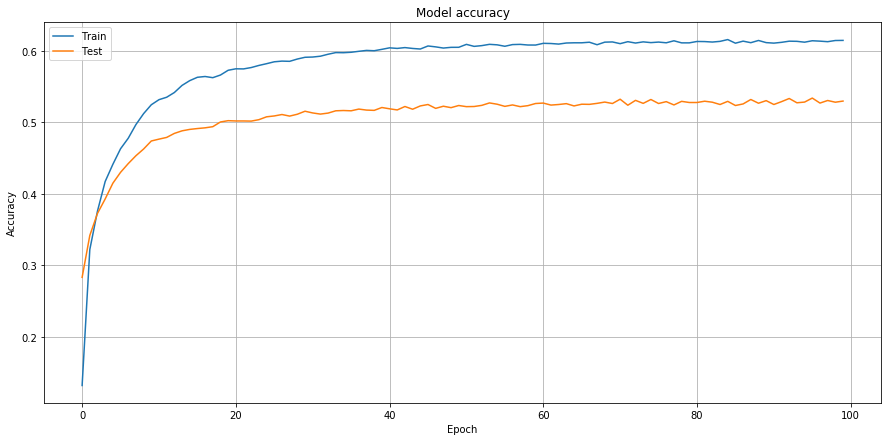

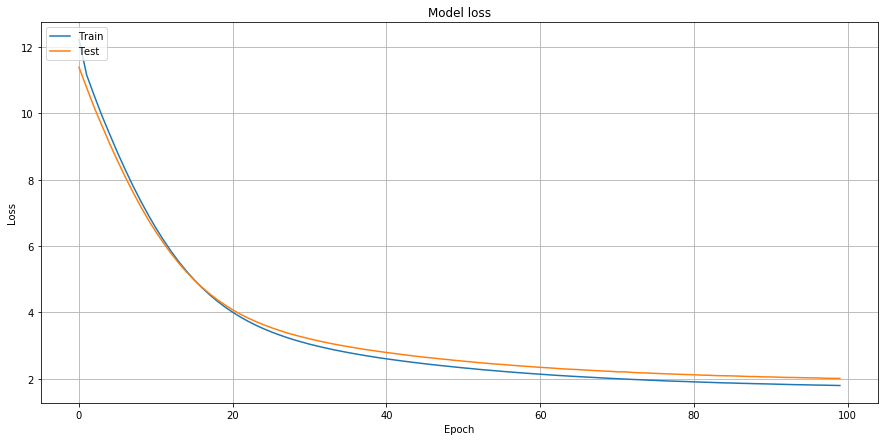

History for neurons = (180, 120)


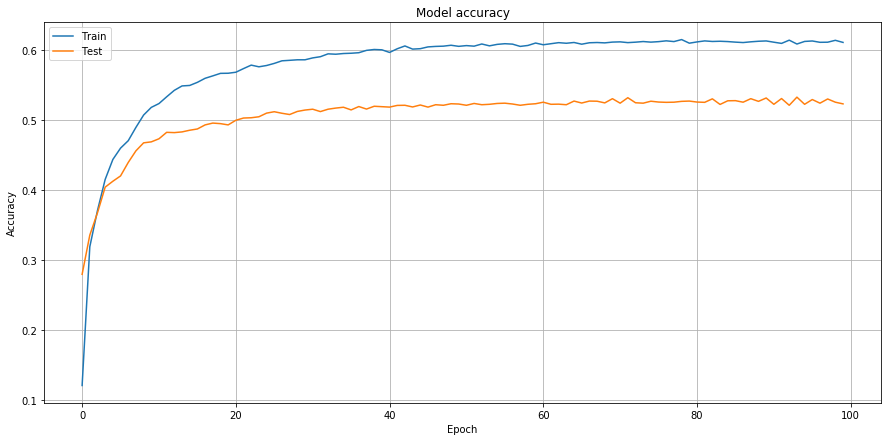

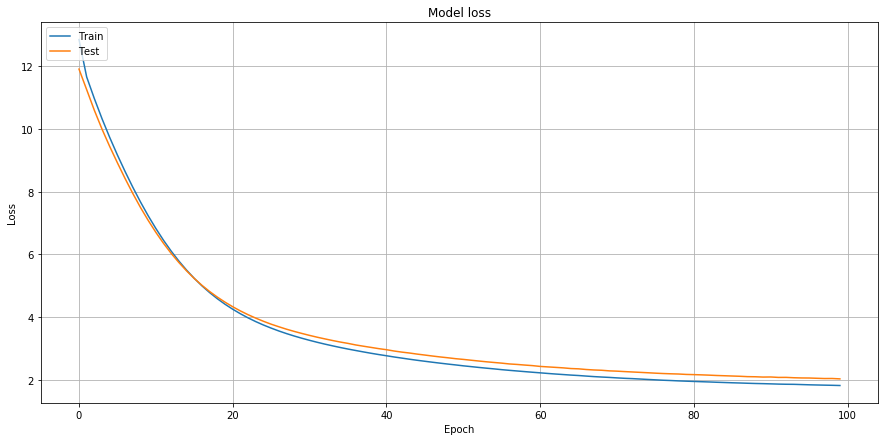

History for neurons = (180, 150)


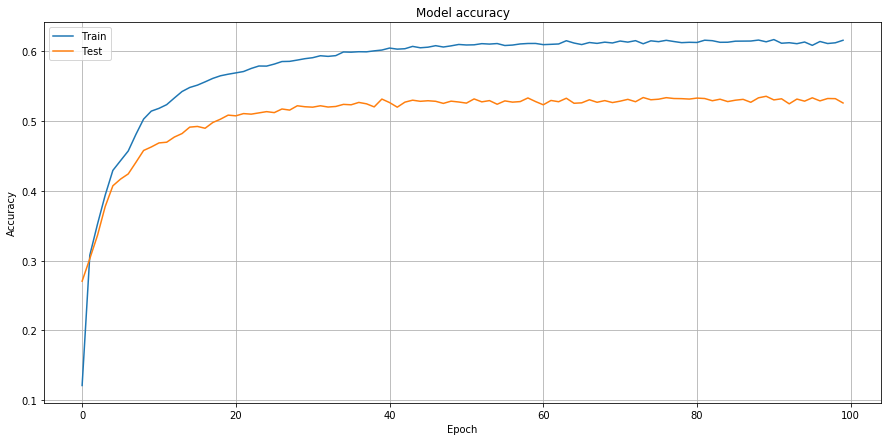

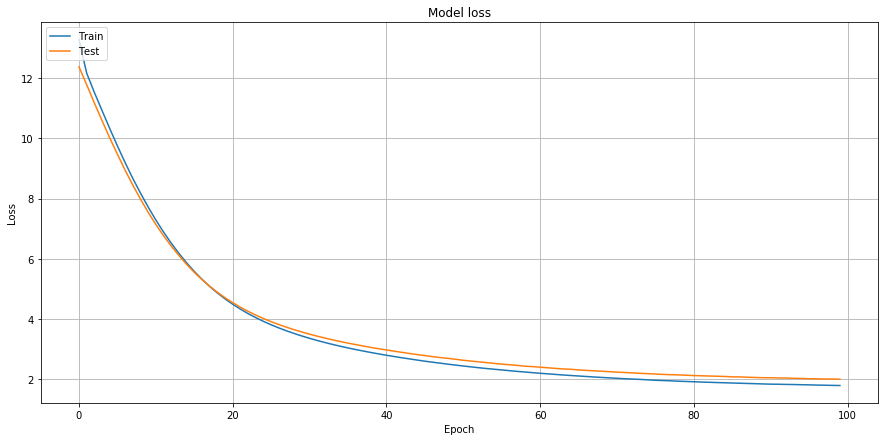

History for neurons = (180, 180)


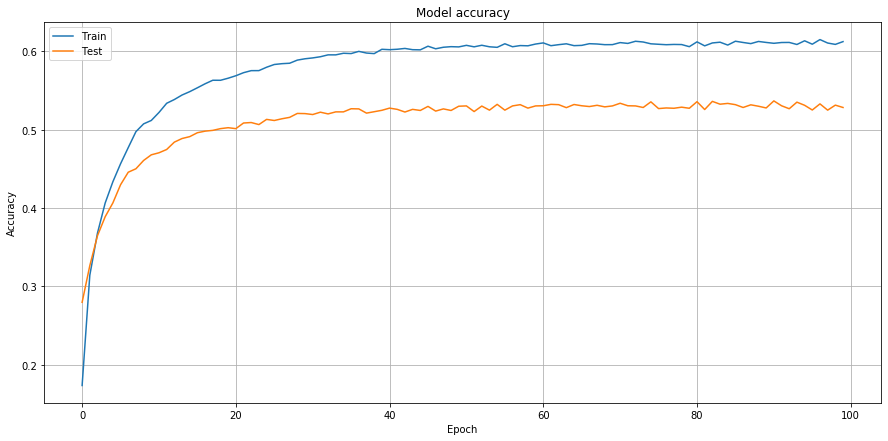

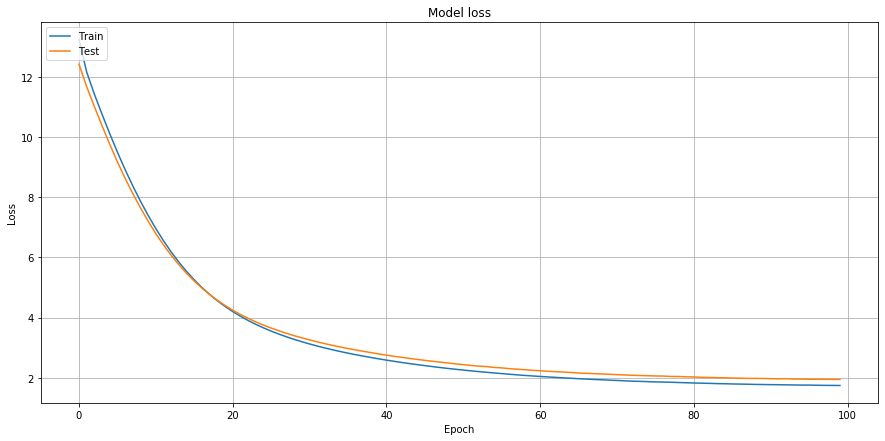

In [132]:
neurons = [i for i in range(30, 200, 30)]
val_accs = []
accs = []
variants = []

for neurons_1 in neurons:
  for neurons_2 in neurons:
    history = fit_model(create_model((neurons_1, neurons_2), alpha_param=0.02))
    val_accs.append(history.history['val_acc'][-1])
    accs.append(history.history['acc'][-1])
    variants.append((neurons_1, neurons_2))
    print(f'History for neurons = {(neurons_1, neurons_2)}')
    print_history(history)

И также проанализируем полученные результаты

In [133]:
overfits = [acc - val_acc for acc, val_acc in zip(accs, val_accs)]
for neurons, acc, val_acc, overfit in zip(variants, accs, val_accs, overfits):
  print(f'Neurons={neurons}. Acc = {round(acc * 100, 2)}%. Val_acc = {round(val_acc * 100, 2)}%. Overfit = {round(overfit * 100, 4)}%')

Neurons=(30, 30). Acc = 53.59%. Val_acc = 48.12%. Overfit = 5.47%
Neurons=(30, 60). Acc = 53.13%. Val_acc = 48.38%. Overfit = 4.75%
Neurons=(30, 90). Acc = 53.36%. Val_acc = 48.52%. Overfit = 4.84%
Neurons=(30, 120). Acc = 54.2%. Val_acc = 48.96%. Overfit = 5.24%
Neurons=(30, 150). Acc = 53.54%. Val_acc = 48.92%. Overfit = 4.62%
Neurons=(30, 180). Acc = 53.07%. Val_acc = 48.16%. Overfit = 4.905%
Neurons=(60, 30). Acc = 57.73%. Val_acc = 50.74%. Overfit = 6.985%
Neurons=(60, 60). Acc = 57.19%. Val_acc = 50.9%. Overfit = 6.285%
Neurons=(60, 90). Acc = 56.77%. Val_acc = 50.36%. Overfit = 6.41%
Neurons=(60, 120). Acc = 57.36%. Val_acc = 50.58%. Overfit = 6.775%
Neurons=(60, 150). Acc = 56.97%. Val_acc = 50.62%. Overfit = 6.355%
Neurons=(60, 180). Acc = 57.75%. Val_acc = 50.9%. Overfit = 6.85%
Neurons=(90, 30). Acc = 59.76%. Val_acc = 51.98%. Overfit = 7.775%
Neurons=(90, 60). Acc = 59.39%. Val_acc = 52.0%. Overfit = 7.385%
Neurons=(90, 90). Acc = 59.13%. Val_acc = 51.1%. Overfit = 8.025%
N

Отсюда видно что оптимальным числом нейронов для заданного альфа будет около 180 нейронов на 1м слое и 30 на втором.

Но вообще логичнее было подбирать одновременно все три параметра в совокупности. Альфа, число нейронов в 1м слое и во 2м. Но это бы заняло очень много времени. А в общем-то почему нет?

## Подбор оптимальной совокупности кол-ва нейронов и параметра альфа

Однако для больше скорости уменьшим число эпох до 60 (потому что по графикам выше заметно, что за это время мы обычно выходим на "плато" по точности, хотя лосс функция продолжает уменьшаться)

In [0]:
neurons = [i for i in range(30, 200, 30)]
alphas = [1, 0.1, 0.05, 0.025, 0.020, 0.015, 0.010, 0.005]
val_accs = []
accs = []
variants = []

for neurons_1 in neurons:
  for neurons_2 in neurons:
    for alpha in alphas:
      history = fit_model(create_model((neurons_1, neurons_2), alpha_param=alpha), epochs=60)
      val_accs.append(history.history['val_acc'][-1])
      accs.append(history.history['acc'][-1])
      variants.append((neurons_1, neurons_2, alpha))
      print(f'History for neurons = {(neurons_1, neurons_2)} and alpha = {alpha}')
      print_history(history)

И опять проанализируем результаты

In [131]:
overfits = [acc - val_acc for acc, val_acc in zip(accs, val_accs)]
for var, acc, val_acc, overfit in zip(variants, accs, val_accs, overfits):
  print(f'Neurons={var[:2]}. Alpha={var[-1]}. Acc = {round(acc * 100, 2)}%. Val_acc = {round(val_acc * 100, 2)}%. Overfit = {round(overfit * 100, 4)}%')

Neurons=(30, 30). Alpha=1. Acc = 31.35%. Val_acc = 29.28%. Overfit = 2.07%
Neurons=(30, 30). Alpha=0.1. Acc = 40.43%. Val_acc = 37.62%. Overfit = 2.815%
Neurons=(30, 30). Alpha=0.05. Acc = 43.09%. Val_acc = 39.5%. Overfit = 3.59%
